In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
import warnings

In [3]:
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')
sns.set(style="whitegrid")

In [4]:
matches = pd.read_csv('/kaggle/input/braindead-data/matches.csv')
deliveries = pd.read_csv('/kaggle/input/braindead-data/deliveries.csv')

In [7]:
print("Matches data shape:", matches.shape)
print("Deliveries data shape:", deliveries.shape)

Matches data shape: (1095, 20)
Deliveries data shape: (260920, 17)


In [8]:
print("\nMatches data head:")
matches.head()


Matches data head:


,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,241.0,20.0,N,NaN,MR Benson,SL Shastri
2,335984,2007/08,Delhi,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,130.0,20.0,N,NaN,Aleem Dar,GA Pratapkumar
3,335985,2007/08,Mumbai,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,166.0,20.0,N,NaN,SJ Davis,DJ Harper
4,335986,2007/08,Kolkata,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,111.0,20.0,N,NaN,BF Bowden,K Hariharan


In [9]:
print("\nMatches data head:")
deliveries.head()


Matches data head:


,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,0,NaN,NaN,NaN
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN


# Data Cleaning and Feature Engineering

##  handling missing values, and outliers

In [10]:
print("\nMissing values in matches dataset:")
matches.isnull().sum()


Missing values in matches dataset:


id                    0
season                0
city                 51
date                  0
match_type            0
player_of_match       5
venue                 0
team1                 0
team2                 0
toss_winner           0
toss_decision         0
winner                5
result                0
result_margin        19
target_runs           3
target_overs          3
super_over            0
method             1074
umpire1               0
umpire2               0
dtype: int64

In [11]:
print("\nMissing values in matches dataset:")
deliveries.isnull().sum()


Missing values in matches dataset:


match_id                 0
inning                   0
batting_team             0
bowling_team             0
over                     0
ball                     0
batter                   0
bowler                   0
non_striker              0
batsman_runs             0
extra_runs               0
total_runs               0
extras_type         246795
is_wicket                0
player_dismissed    247970
dismissal_kind      247970
fielder             251566
dtype: int64

In [12]:
def fill_city(df: pd.DataFrame) -> pd.DataFrame:

    for index, row in df[df["city"].isnull()].iterrows():
        venue_name = row["venue"]

        # Find rows with the same venue
        matching_rows = df[df["venue"] == venue_name]

        # Get unique non-null city values for that venue
        known_cities = matching_rows["city"].dropna().unique()

        if len(known_cities) > 0:
            # Fill the missing city with the first known city
            df.at[index, "city"] = known_cities[0]
        else:
            # Log a message if no city is found for the venue
            print(f"No city found for venue: {venue_name}")

    return df

In [13]:
matches[matches['player_of_match'].isnull()]

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
241,501265,2011,Delhi,2011-05-21,League,NaN,Feroz Shah Kotla,Delhi Daredevils,Pune Warriors,Delhi Daredevils,bat,NaN,no result,NaN,NaN,NaN,N,NaN,SS Hazare,RJ Tucker
485,829763,2015,Bangalore,2015-04-29,League,NaN,M Chinnaswamy Stadium,Royal Challengers Bangalore,Rajasthan Royals,Rajasthan Royals,field,NaN,no result,NaN,NaN,NaN,N,NaN,JD Cloete,PG Pathak
511,829813,2015,Bangalore,2015-05-17,League,NaN,M Chinnaswamy Stadium,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,field,NaN,no result,NaN,188.0,20.0,N,NaN,HDPK Dharmasena,K Srinivasan
744,1178424,2019,Bengaluru,2019-04-30,League,NaN,M.Chinnaswamy Stadium,Royal Challengers Bangalore,Rajasthan Royals,Rajasthan Royals,field,NaN,no result,NaN,63.0,5.0,N,NaN,NJ Llong,UV Gandhe
994,1359519,2023,Lucknow,2023-05-03,League,NaN,Bharat Ratna Shri Atal Bihari Vajpayee Ekana C...,Lucknow Super Giants,Chennai Super Kings,Chennai Super Kings,field,NaN,no result,NaN,NaN,NaN,N,NaN,AK Chaudhary,NA Patwardhan


In [14]:
# Handle missing values in matches dataset
matches = fill_city(matches) # fill city
matches.dropna(subset=['player_of_match'], inplace=True)
matches['result_margin'].fillna(0, inplace=True)
matches['method'].fillna('Not Applicable', inplace=True)




In [15]:
matches.isnull().sum()

id                 0
season             0
city               0
date               0
match_type         0
player_of_match    0
venue              0
team1              0
team2              0
toss_winner        0
toss_decision      0
winner             0
result             0
result_margin      0
target_runs        0
target_overs       0
super_over         0
method             0
umpire1            0
umpire2            0
dtype: int64

In [16]:
deliveries['extras_type'].fillna('None', inplace=True)
deliveries['player_dismissed'].fillna('None', inplace=True)  # No player dismissed
deliveries['dismissal_kind'].fillna('Not Out', inplace=True) # No dismissal occurred
deliveries['fielder'].fillna('None', inplace=True)
print(deliveries.isnull().sum())

match_id            0
inning              0
batting_team        0
bowling_team        0
over                0
ball                0
batter              0
bowler              0
non_striker         0
batsman_runs        0
extra_runs          0
total_runs          0
extras_type         0
is_wicket           0
player_dismissed    0
dismissal_kind      0
fielder             0
dtype: int64


## Null values handled

# Standardize team names 

In [17]:

matches.replace({'team1': 'Delhi Daredevils', 'team2': 'Delhi Daredevils', 
                 'winner': 'Delhi Daredevils', 'toss_winner': 'Delhi Daredevils'}, 
                'Delhi Capitals', inplace=True)

# Replace Deccan Chargers with Sunrisers Hyderabad (as they replaced them in 2012)
matches.replace({'team1': 'Deccan Chargers', 'team2': 'Deccan Chargers', 
                 'winner': 'Deccan Chargers', 'toss_winner': 'Deccan Chargers'}, 
                'Sunrisers Hyderabad', inplace=True)

# Convert date to datetime format for time-based analysis
matches['date'] = pd.to_datetime(matches['date'])
matches['season'] = matches['date'].dt.year

In [18]:
deliveries['batting_team'] = deliveries['batting_team'].replace('Delhi Daredevils', 'Delhi Capitals')
deliveries['bowling_team'] = deliveries['bowling_team'].replace('Delhi Daredevils', 'Delhi Capitals')


# Update batting and bowling teams in deliveries
deliveries['batting_team'] = deliveries['batting_team'].replace('Deccan Chargers', 'Sunrisers Hyderabad')
deliveries['bowling_team'] = deliveries['bowling_team'].replace('Deccan Chargers', 'Sunrisers Hyderabad')

# **Exploratory Data Analysis (EDA)**
 ---

## Plot Matches Played and Winning Percentages

In [19]:
# Extract Features from the datasets
# =================================

# 1. Team Performance Metrics
# Team win percentages
team_wins = matches['winner'].value_counts().reset_index()
team_wins.columns = ['team', 'wins']

# Total matches played by each team
team1_matches = matches['team1'].value_counts().reset_index()
team1_matches.columns = ['team', 'matches_as_team1']
team2_matches = matches['team2'].value_counts().reset_index()
team2_matches.columns = ['team', 'matches_as_team2']

team_matches = pd.merge(team1_matches, team2_matches, on='team', how='outer')
team_matches['total_matches'] = team_matches['matches_as_team1'] + team_matches['matches_as_team2']
team_matches.fillna(0, inplace=True)

# Merge wins and matches
team_performance = pd.merge(team_matches, team_wins, on='team', how='left')
team_performance.fillna(0, inplace=True)  # Teams with 0 wins
team_performance['win_percentage'] = (team_performance['wins'] / team_performance['total_matches'] * 100).round(2)

print("\nTeam Performance Summary:")
team_performance[['team', 'total_matches', 'wins', 'win_percentage']].sort_values('win_percentage', ascending=False)


Team Performance Summary:


,team,total_matches,wins,win_percentage
12,Rising Pune Supergiant,16,10,62.50
3,Gujarat Titans,45,28,62.22
0,Chennai Super Kings,237,138,58.23
7,Lucknow Super Giants,43,24,55.81
8,Mumbai Indians,261,144,55.17
6,Kolkata Knight Riders,251,131,52.19
11,Rajasthan Royals,219,112,51.14
14,Royal Challengers Bangalore,237,116,48.95
15,Royal Challengers Bengaluru,15,7,46.67
4,Kings XI Punjab,190,88,46.32


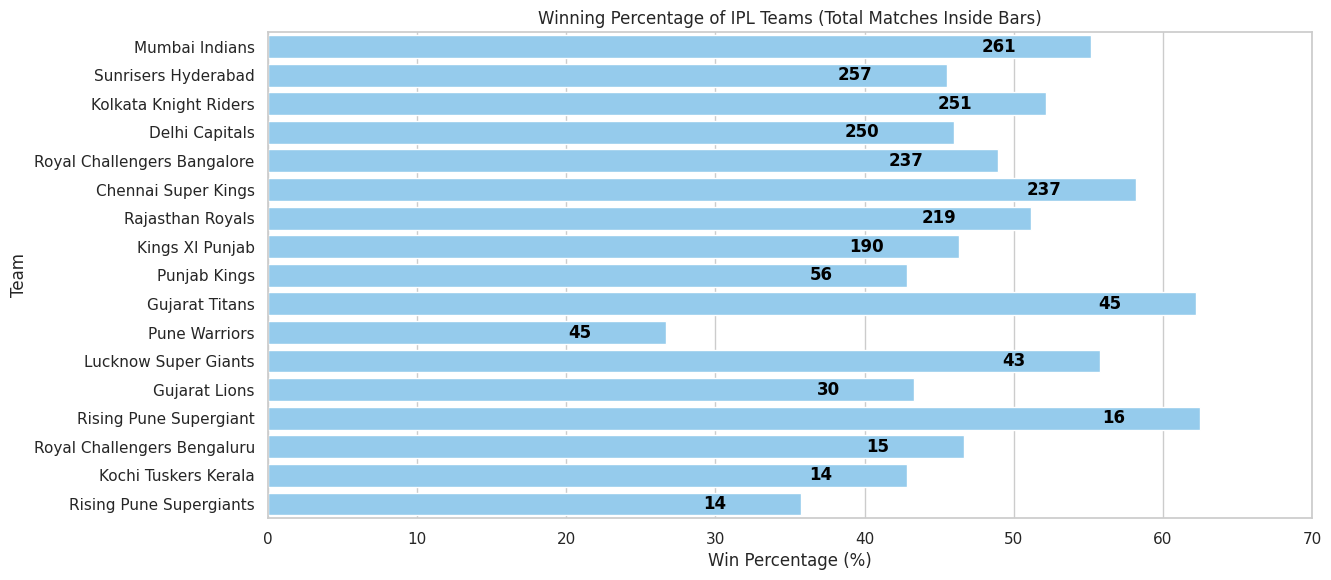

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sort DataFrame by Total Matches
df = team_performance[['team', 'total_matches', 'win_percentage']].sort_values(by="total_matches", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df, y="team", x="win_percentage", color="lightskyblue")

# Get correct y-axis positions
y_positions = ax.get_yticks()

# Add text annotations inside the bars
for pos, (team, total_matches, win_percentage) in zip(y_positions, df[['team', 'total_matches', 'win_percentage']].values):
    ax.text(win_percentage - 5, pos, f"{total_matches}", 
            color='black', ha='right', va='center', fontsize=12, fontweight='bold')
    # print(team, total_matches)

# Labels and Title
plt.xlabel("Win Percentage (%)")
plt.ylabel("Team")
plt.title("Winning Percentage of IPL Teams (Total Matches Inside Bars)")
plt.xlim(0, 70)

# Show Plot
plt.show()


# Plot Run Rate and Economy Rate (as a bowling side)

In [21]:
# 2. Batting and Bowling Metrics

# Calculate Runs per Team
team_runs = deliveries.groupby('batting_team')['total_runs'].sum().reset_index()
team_runs.columns = ['team', 'total_runs']

# Calculate Balls Faced per Team
team_balls = deliveries.groupby('batting_team').size().reset_index()
team_balls.columns = ['team', 'balls_faced']

# Merge runs and balls
team_batting = pd.merge(team_runs, team_balls, on='team', how='left')
team_batting['run_rate'] = (team_batting['total_runs'] / (team_batting['balls_faced'] / 6)).round(2)

# Calculate Economy Rate
team_runs_conceded = deliveries.groupby('bowling_team')['total_runs'].sum().reset_index()
team_runs_conceded.columns = ['team', 'runs_conceded']

team_balls_bowled = deliveries.groupby('bowling_team').size().reset_index()
team_balls_bowled.columns = ['team', 'balls_bowled']

team_bowling = pd.merge(team_runs_conceded, team_balls_bowled, on='team', how='left')
team_bowling['economy_rate'] = (team_bowling['runs_conceded'] / (team_bowling['balls_bowled'] / 6)).round(2)

In [22]:
# Combine batting and bowling metrics
team_metrics = pd.merge(team_batting, team_bowling, on='team', how='left')
print("\nTeam Batting and Bowling Metrics:")
team_metrics[['team', 'run_rate', 'economy_rate']].sort_values('run_rate', ascending=False)


Team Batting and Bowling Metrics:


,team,run_rate,economy_rate
15,Royal Challengers Bengaluru,9.67,9.39
3,Gujarat Titans,8.47,8.46
10,Punjab Kings,8.37,8.52
7,Lucknow Super Giants,8.34,8.51
2,Gujarat Lions,8.18,8.61
0,Chennai Super Kings,8.09,7.81
8,Mumbai Indians,8.05,7.86
14,Royal Challengers Bangalore,8.02,8.04
6,Kolkata Knight Riders,8.00,7.91
4,Kings XI Punjab,7.97,8.13


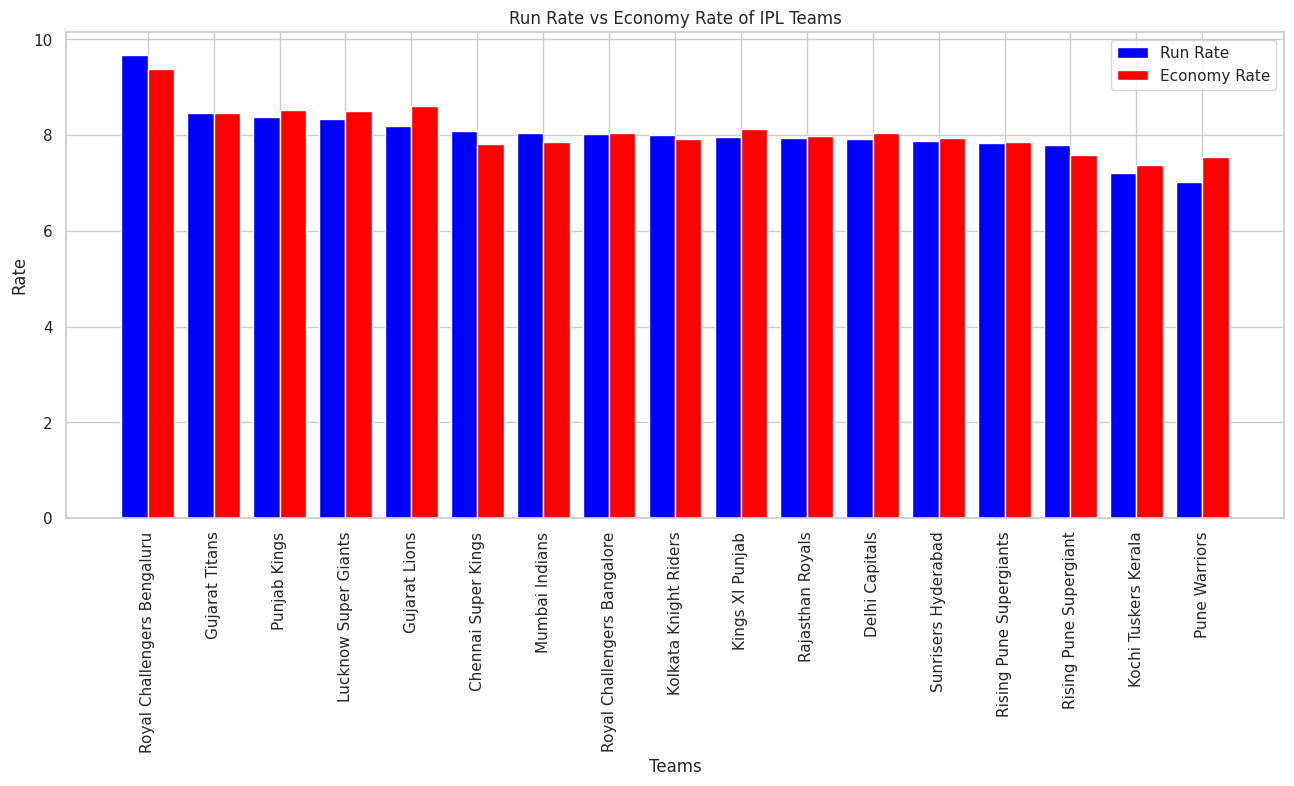

In [23]:
# Sort DataFrame by Run Rate
df = team_metrics[['team', 'run_rate', 'economy_rate']].sort_values(by="run_rate", ascending=False)

# Set width for grouped bars
bar_width = 0.4
x = np.arange(len(df))  # X positions for bars

# Create figure
plt.figure(figsize=(14, 6))
plt.bar(x - bar_width/2, df['run_rate'], width=bar_width, label="Run Rate", color='blue')
plt.bar(x + bar_width/2, df['economy_rate'], width=bar_width, label="Economy Rate", color='red')

# Add team names to X-axis
plt.xticks(x, df['team'], rotation=90)

# Labels and title
plt.xlabel("Teams")
plt.ylabel("Rate")
plt.title("Run Rate vs Economy Rate of IPL Teams")
plt.legend()

# Show plot
plt.show()

# Plot Highest and Lowest Scores

In [24]:
# 3. Highest and Lowest Team Scores

# Calculate highest scores
matches_with_scores = matches.copy()
match_scores = deliveries.groupby(['match_id', 'inning', 'batting_team'])['total_runs'].sum().reset_index()

highest_scores = match_scores.sort_values('total_runs', ascending=False).head(10)
highest_scores = pd.merge(highest_scores, matches[['id', 'date', 'venue']], left_on='match_id', right_on='id', how='left')
print("\nHighest Team Scores:")
highest_scores[['batting_team', 'total_runs', 'date', 'venue']]


Highest Team Scores:


,batting_team,total_runs,date,venue
0,Sunrisers Hyderabad,287,2024-04-15,"M Chinnaswamy Stadium, Bengaluru"
1,Sunrisers Hyderabad,277,2024-03-27,"Rajiv Gandhi International Stadium, Uppal, Hyd..."
2,Kolkata Knight Riders,272,2024-04-03,Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket St...
3,Sunrisers Hyderabad,266,2024-04-20,"Arun Jaitley Stadium, Delhi"
4,Royal Challengers Bangalore,263,2013-04-23,M Chinnaswamy Stadium
5,Punjab Kings,262,2024-04-26,"Eden Gardens, Kolkata"
6,Royal Challengers Bengaluru,262,2024-04-15,"M Chinnaswamy Stadium, Bengaluru"
7,Kolkata Knight Riders,261,2024-04-26,"Eden Gardens, Kolkata"
8,Delhi Capitals,257,2024-04-27,"Arun Jaitley Stadium, Delhi"
9,Lucknow Super Giants,257,2023-04-28,"Punjab Cricket Association IS Bindra Stadium, ..."


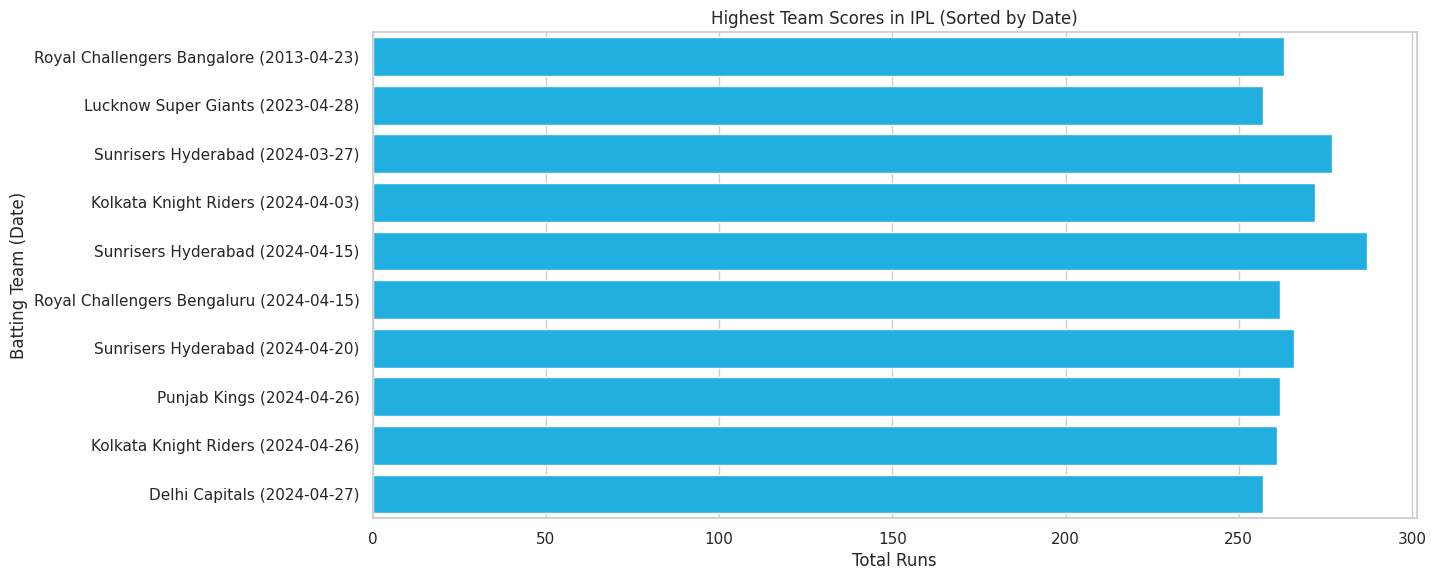

In [25]:

df = highest_scores[['batting_team', 'total_runs', 'date', 'venue']].copy()
df['date'] = pd.to_datetime(df['date'])

# Sort by date
df = df.sort_values(by='date', ascending=True)

# Create a new column for the y-axis: "Team (Date)"
df['team_date'] = df['batting_team'] + " (" + df['date'].dt.strftime('%Y-%m-%d') + ")"

# Create the plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df, y="team_date", x="total_runs", color="deepskyblue")


# Labels and title
plt.xlabel("Total Runs")
plt.ylabel("Batting Team (Date)")
plt.title("Highest Team Scores in IPL (Sorted by Date)")

# Show plot
plt.show()

In [26]:
lowest_scores = match_scores[match_scores['total_runs'] > 0]
lowest_scores = pd.merge(lowest_scores, matches[['id', 'date', 'venue']], left_on='match_id', right_on='id', how='left')

lowest_scores = lowest_scores.dropna(subset=['date', 'venue'])
lowest_scores = lowest_scores.sort_values('total_runs').head(10)


print("\nLowest Team Scores:")
lowest_scores[['batting_team', 'total_runs', 'date', 'venue']]


Lowest Team Scores:


,batting_team,total_runs,date,venue
1572,Sunrisers Hyderabad,2,2020-10-18,Sheikh Zayed Stadium
1532,Kings XI Punjab,2,2020-09-20,Dubai International Cricket Stadium
1533,Delhi Capitals,3,2020-09-20,Dubai International Cricket Stadium
1573,Kolkata Knight Riders,3,2020-10-18,Sheikh Zayed Stadium
1584,Kings XI Punjab,5,2020-10-18,Dubai International Cricket Stadium
1585,Mumbai Indians,5,2020-10-18,Dubai International Cricket Stadium
964,Rajasthan Royals,6,2015-04-21,"Sardar Patel Stadium, Motera"
1233,Gujarat Lions,6,2017-04-29,Saurashtra Cricket Association Stadium
1698,Sunrisers Hyderabad,7,2021-04-25,"MA Chidambaram Stadium, Chepauk, Chennai"
1425,Kolkata Knight Riders,7,2019-03-30,Arun Jaitley Stadium


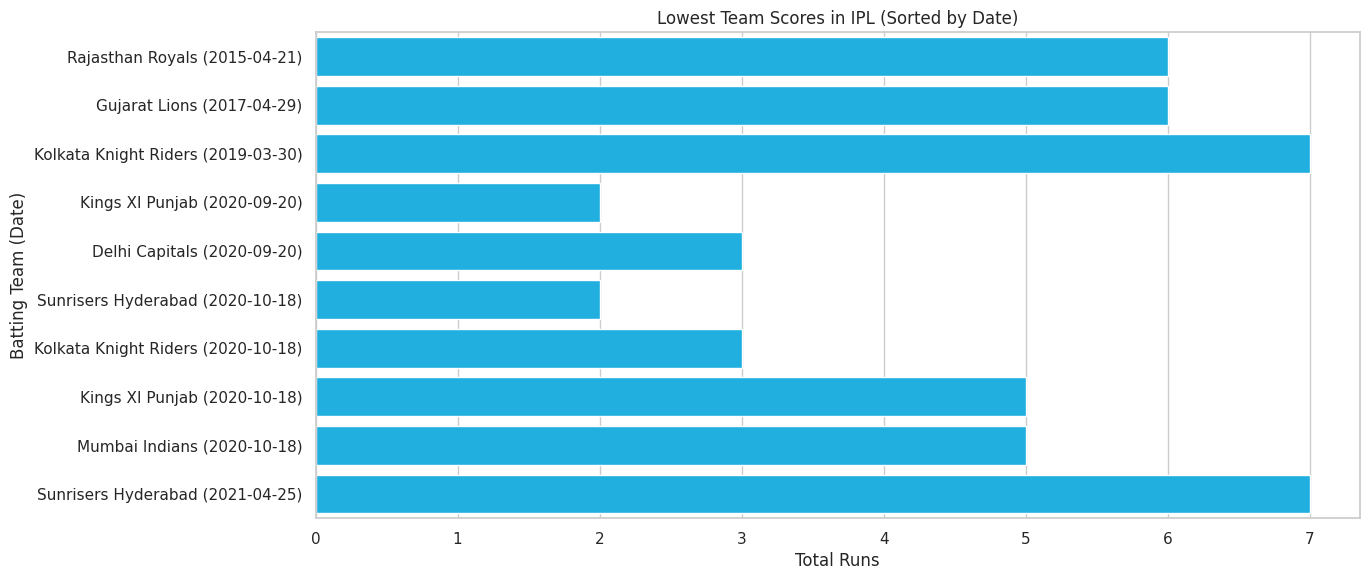

In [27]:
df = lowest_scores[['batting_team', 'total_runs', 'date', 'venue']].copy()
df['date'] = pd.to_datetime(df['date'])

# Sort by date
df = df.sort_values(by='date', ascending=True)

# Create a new column for the y-axis: "Team (Date)"
df['team_date'] = df['batting_team'] + " (" + df['date'].dt.strftime('%Y-%m-%d') + ")"

# Create the plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df, y="team_date", x="total_runs",color="deepskyblue")



# Labels and title
plt.xlabel("Total Runs")
plt.ylabel("Batting Team (Date)")
plt.title("Lowest Team Scores in IPL (Sorted by Date)")

# Show plot
plt.show()

# Plot Total 4s and 6s

In [28]:
# 4. Total 4s and 6s by Teams
fours = deliveries[deliveries['batsman_runs'] == 4].groupby('batting_team').size().reset_index()
fours.columns = ['team', 'total_fours']

sixes = deliveries[deliveries['batsman_runs'] == 6].groupby('batting_team').size().reset_index()
sixes.columns = ['team', 'total_sixes']

boundaries = pd.merge(fours, sixes, on='team', how='outer')
boundaries.fillna(0, inplace=True)
print("\nTotal Boundaries by Teams:")
boundaries.sort_values('total_sixes', ascending=False)


Total Boundaries by Teams:


,team,total_fours,total_sixes
8,Mumbai Indians,3637,1685
0,Chennai Super Kings,3196,1509
6,Kolkata Knight Riders,3461,1495
14,Royal Challengers Bangalore,3149,1488
16,Sunrisers Hyderabad,3362,1442
1,Delhi Capitals,3508,1351
11,Rajasthan Royals,3091,1237
4,Kings XI Punjab,2631,1075
10,Punjab Kings,795,440
7,Lucknow Super Giants,577,332


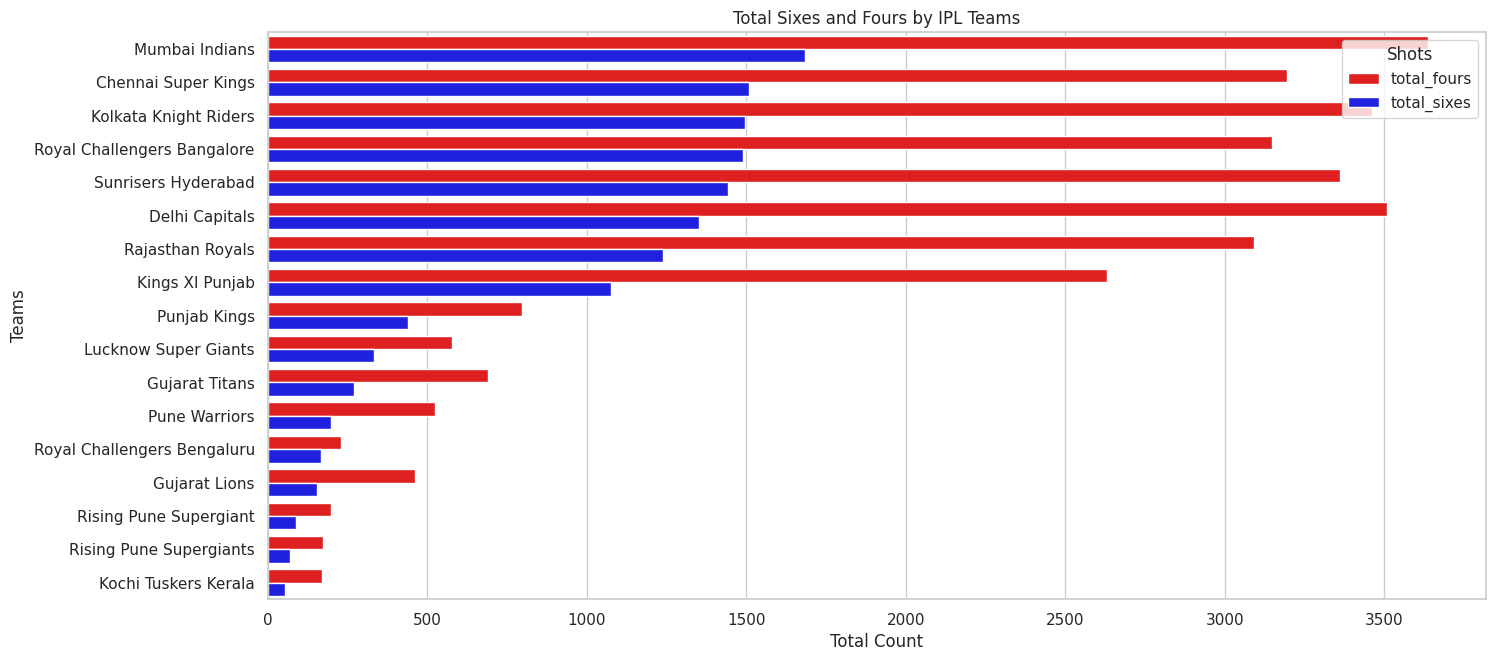

In [29]:
df = boundaries.sort_values('total_sixes', ascending=False)

# Plot
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=df.melt(id_vars="team", var_name="Type", value_name="Count"),
                 x="Count", y="team", hue="Type", palette=["red", "blue"])

# Labels and title
plt.xlabel("Total Count")
plt.ylabel("Teams")
plt.title("Total Sixes and Fours by IPL Teams")
plt.legend(title="Shots", loc="upper right")

# Show plot
plt.show()

# Plot Average Powerplay and Death Overs Score

In [30]:
# 5. Powerplay and Death Overs Analysis

# Powerplay (first 6 overs) analysis
powerplay_runs = deliveries[(deliveries['over'] < 6)].groupby('batting_team')['total_runs'].sum().reset_index()
powerplay_balls = deliveries[(deliveries['over'] < 6)].groupby('batting_team').size().reset_index()
powerplay_balls.columns = ['batting_team', 'balls']
powerplay = pd.merge(powerplay_runs, powerplay_balls, on='batting_team', how='left')
powerplay['avg_powerplay_score'] = (powerplay['total_runs'] * 36 / powerplay['balls']).round(2)
print("\nAverage Powerplay Score by Teams:")
powerplay[['batting_team', 'avg_powerplay_score']].sort_values('avg_powerplay_score', ascending=False)


Average Powerplay Score by Teams:


,batting_team,avg_powerplay_score
15,Royal Challengers Bengaluru,57.13
2,Gujarat Lions,49.89
10,Punjab Kings,48.73
12,Rising Pune Supergiant,47.26
3,Gujarat Titans,46.63
16,Sunrisers Hyderabad,46.15
1,Delhi Capitals,46.05
5,Kochi Tuskers Kerala,45.93
6,Kolkata Knight Riders,45.56
7,Lucknow Super Giants,45.55


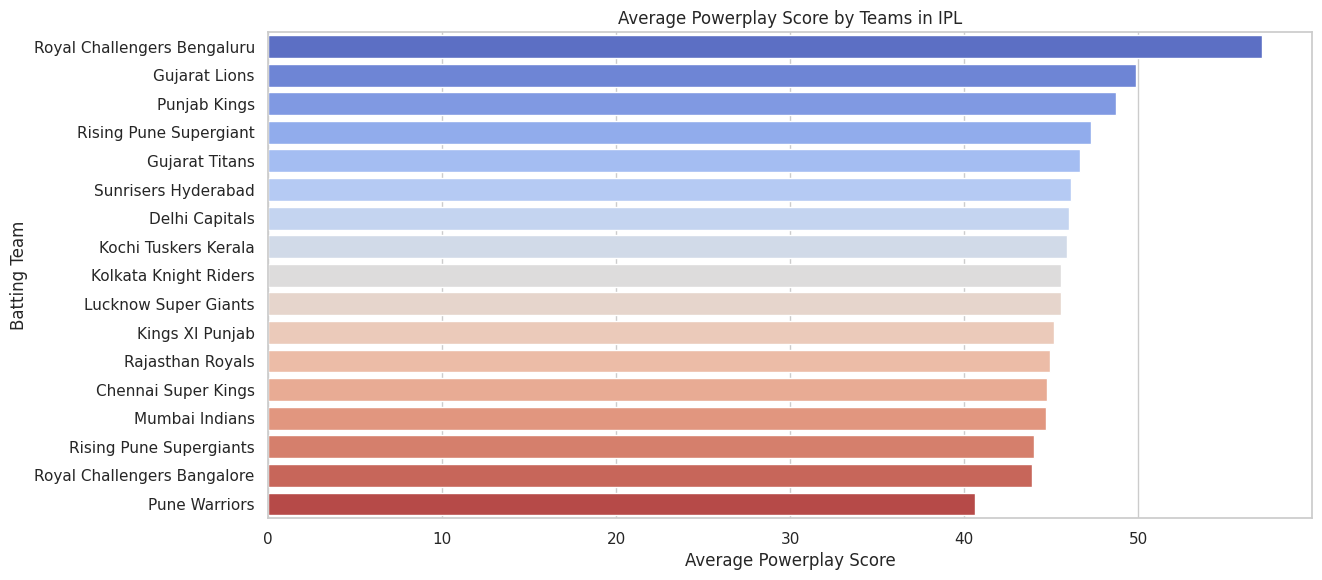

In [31]:
df = powerplay[['batting_team', 'avg_powerplay_score']].sort_values('avg_powerplay_score', ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df, y="batting_team", x="avg_powerplay_score", palette="coolwarm")



# Labels and Title
plt.xlabel("Average Powerplay Score")
plt.ylabel("Batting Team")
plt.title("Average Powerplay Score by Teams in IPL")

# Show Plot
plt.show()

In [32]:
# Death overs (last 4 overs) analysis
death_runs = deliveries[(deliveries['over'] >= 16) & (deliveries['over'] <= 20)].groupby('batting_team')['total_runs'].sum().reset_index()
death_balls = deliveries[(deliveries['over'] >= 16) & (deliveries['over'] <= 20)].groupby('batting_team').size().reset_index()
death_balls.columns = ['batting_team', 'balls']
death = pd.merge(death_runs, death_balls, on='batting_team', how='left')
death['avg_death_score'] = (death['total_runs'] * 24 / death['balls']).round(2)
print("\nAverage Death Overs Score by Teams:")
death[['batting_team', 'avg_death_score']].sort_values('avg_death_score', ascending=False)


Average Death Overs Score by Teams:


,batting_team,avg_death_score
15,Royal Challengers Bengaluru,43.38
3,Gujarat Titans,42.44
13,Rising Pune Supergiants,41.53
0,Chennai Super Kings,41.07
14,Royal Challengers Bangalore,40.73
8,Mumbai Indians,40.32
7,Lucknow Super Giants,40.23
10,Punjab Kings,38.99
6,Kolkata Knight Riders,38.46
1,Delhi Capitals,38.30


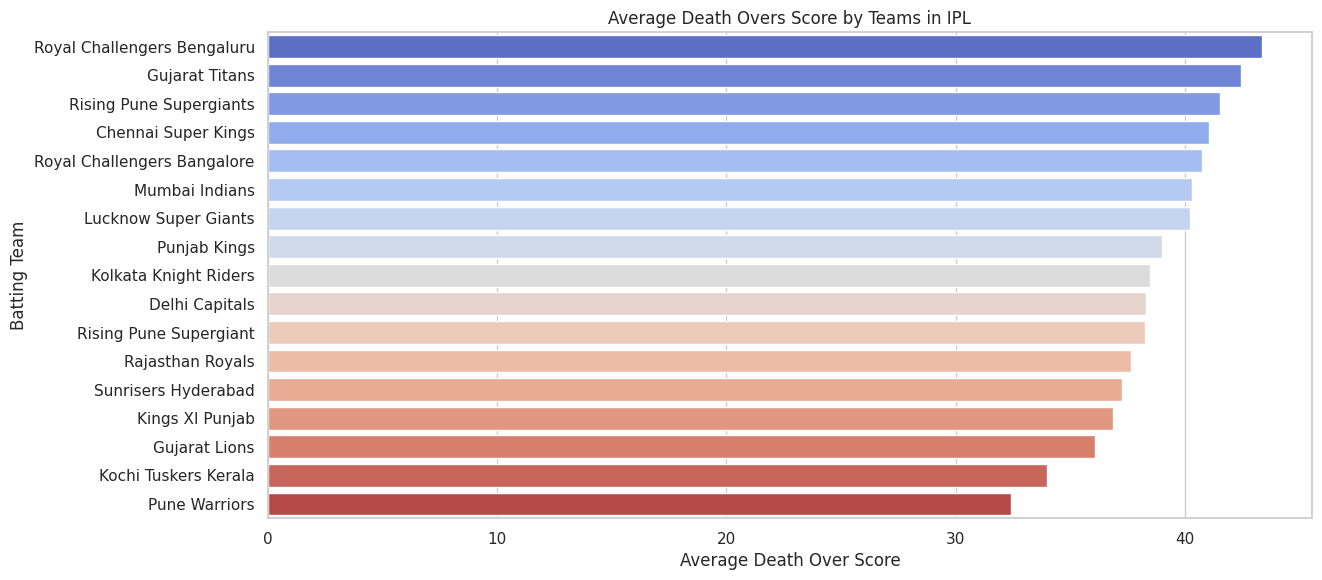

In [33]:
df = death[['batting_team', 'avg_death_score']].sort_values('avg_death_score', ascending=False)
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df, y="batting_team", x="avg_death_score", palette="coolwarm")



# Labels and Title
plt.xlabel("Average Death Over Score")
plt.ylabel("Batting Team")
plt.title("Average Death Overs Score by Teams in IPL")

# Show Plot
plt.show()

# Average run per over of each team (as a batting side)

In [34]:
# 6. Average Run per Over
# Step 1: Get total runs per team per match per over
over_runs = deliveries.groupby(['match_id', 'batting_team', 'over'])['total_runs'].sum().reset_index()

# Step 2: Calculate average runs per over for each team
avg_over_runs = over_runs.groupby(['batting_team', 'over'])['total_runs'].mean().reset_index()

print("\nAverage Runs per Over (Corrected Sample):")
print(avg_over_runs.head(10))



Average Runs per Over (Corrected Sample):
          batting_team  over  total_runs
0  Chennai Super Kings     0    5.282700
1  Chennai Super Kings     1    6.784810
2  Chennai Super Kings     2    7.755274
3  Chennai Super Kings     3    8.481013
4  Chennai Super Kings     4    8.831224
5  Chennai Super Kings     5    9.240506
6  Chennai Super Kings     6    6.919831
7  Chennai Super Kings     7    7.126582
8  Chennai Super Kings     8    7.825532
9  Chennai Super Kings     9    7.302128


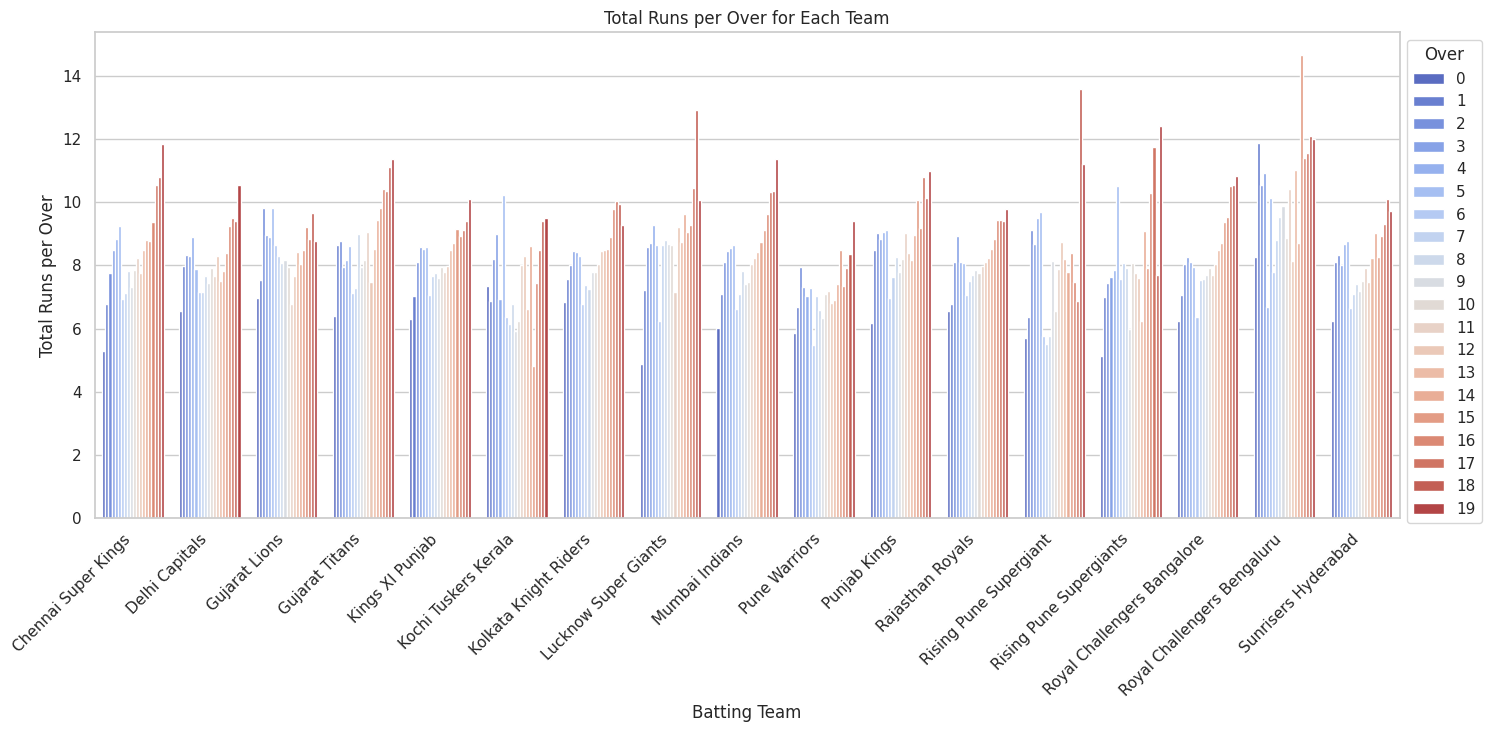

In [35]:
plt.figure(figsize=(15, 6))
ax = sns.barplot(data=avg_over_runs, x="batting_team", y="total_runs", hue="over", palette="coolwarm")

# Labels and Title
plt.xlabel("Batting Team")
plt.ylabel("Total Runs per Over")
plt.title("Total Runs per Over for Each Team")
plt.legend(title="Over", bbox_to_anchor=(1, 1))  # Move legend outside for clarity

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show Plot
plt.show()

In [36]:
# Player Performance Analysis
# ==========================

# 1. Top Run Scorers
batsman_runs = deliveries.groupby('batter')['batsman_runs'].sum().reset_index()
batsman_matches = deliveries.groupby('batter')['match_id'].nunique().reset_index()
batsman_matches.columns = ['batter', 'matches']
batsman_innings = deliveries.groupby(['batter', 'match_id', 'inning']).size().reset_index()
batsman_innings = batsman_innings.groupby('batter').size().reset_index()
batsman_innings.columns = ['batter', 'innings']

batsman_balls = deliveries.groupby('batter').size().reset_index()
batsman_balls.columns = ['batter', 'balls_faced']

batsman_fours = deliveries[deliveries['batsman_runs'] == 4].groupby('batter').size().reset_index()
batsman_fours.columns = ['batter', 'fours']

batsman_sixes = deliveries[deliveries['batsman_runs'] == 6].groupby('batter').size().reset_index()
batsman_sixes.columns = ['batter', 'sixes']

# Merge all batsman stats
batsman_stats = pd.merge(batsman_runs, batsman_matches, on='batter', how='left')
batsman_stats = pd.merge(batsman_stats, batsman_innings, on='batter', how='left')
batsman_stats = pd.merge(batsman_stats, batsman_balls, on='batter', how='left')
batsman_stats = pd.merge(batsman_stats, batsman_fours, on='batter', how='left')
batsman_stats = pd.merge(batsman_stats, batsman_sixes, on='batter', how='left')
batsman_stats.fillna(0, inplace=True)

# Calculate batting average and strike rate
batsman_stats['batting_avg'] = (batsman_stats['batsman_runs'] / batsman_stats['innings']).round(2)
batsman_stats['strike_rate'] = (batsman_stats['batsman_runs'] / batsman_stats['balls_faced'] * 100).round(2)

top_batsmen = batsman_stats.sort_values('batsman_runs', ascending=False).head(20)
print("\nTop 20 Run Scorers:")
top_batsmen[['batter', 'batsman_runs', 'matches', 'batting_avg', 'strike_rate', 'fours', 'sixes']]


Top 20 Run Scorers:


,batter,batsman_runs,matches,batting_avg,strike_rate,fours,sixes
631,V Kohli,8014,244,32.58,128.51,708.0,273.0
512,S Dhawan,6769,221,30.49,123.45,768.0,153.0
477,RG Sharma,6630,251,26.31,127.92,599.0,281.0
147,DA Warner,6567,184,35.12,135.43,663.0,236.0
546,SK Raina,5536,200,27.54,132.54,506.0,204.0
374,MS Dhoni,5243,228,23.00,132.84,363.0,252.0
30,AB de Villiers,5181,170,30.12,148.58,414.0,253.0
124,CH Gayle,4997,141,34.46,142.12,408.0,359.0
501,RV Uthappa,4954,197,25.02,126.15,481.0,182.0
282,KD Karthik,4843,233,20.61,131.35,466.0,161.0


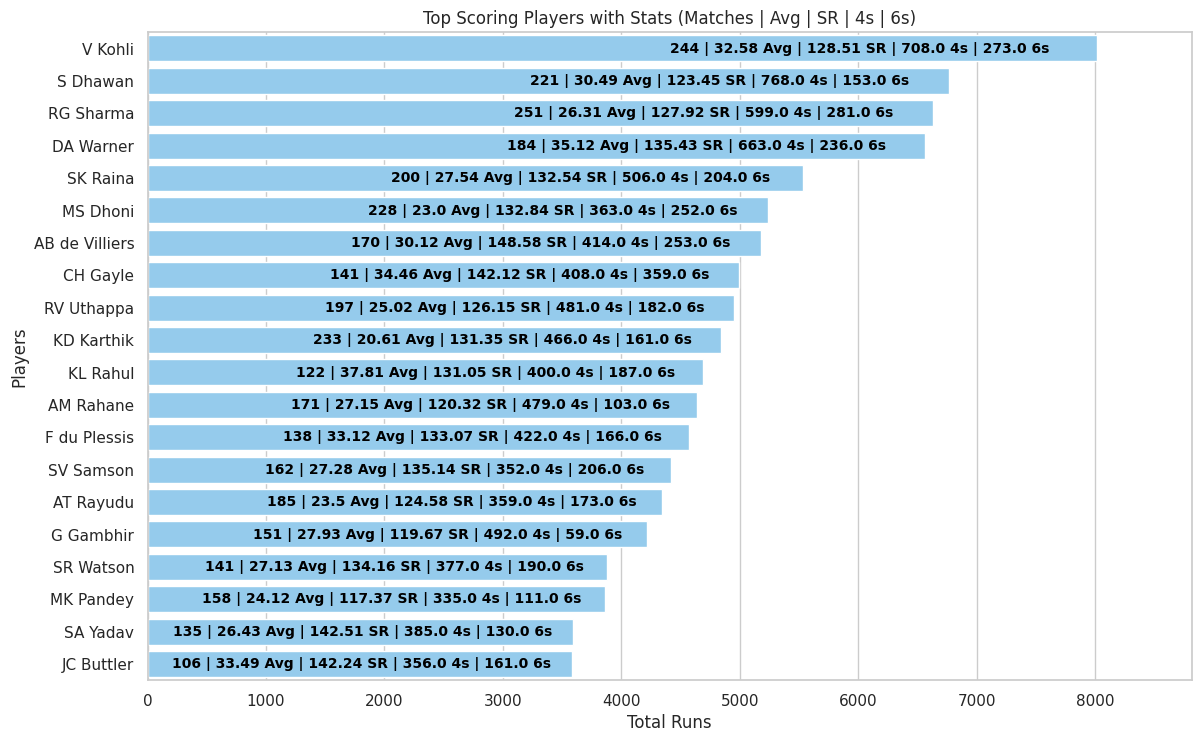

In [37]:
# Sort DataFrame by Total Runs
df = top_batsmen[['batter', 'batsman_runs', 'matches', 'batting_avg', 'strike_rate', 'fours', 'sixes']].sort_values(by="batsman_runs", ascending=False)

# Set up the figure
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=df, y="batter", x="batsman_runs", color="lightskyblue")

# Get correct y-axis positions
y_positions = ax.get_yticks()

# Add labels inside bars
for pos, (batter, batsman_runs, matches_no, batting_avg, strike_rate, fours, sixes) in zip(y_positions, df[['batter', 'batsman_runs', 'matches', 'batting_avg', 'strike_rate', 'fours', 'sixes']].values):
    label = f"{matches_no} | {batting_avg} Avg | {strike_rate} SR | {fours} 4s | {sixes} 6s"
    ax.text(batsman_runs - (batsman_runs * 0.05), pos, label, 
            color="black", ha="right", va="center", fontsize=10, fontweight="bold")

# Labels and title
plt.xlabel("Total Runs")
plt.ylabel("Players")
plt.title("Top Scoring Players with Stats (Matches | Avg | SR | 4s | 6s)")
plt.xlim(0, df["batsman_runs"].max() * 1.1)  # Adjust x-axis limit for better spacing

# Show plot
plt.show()

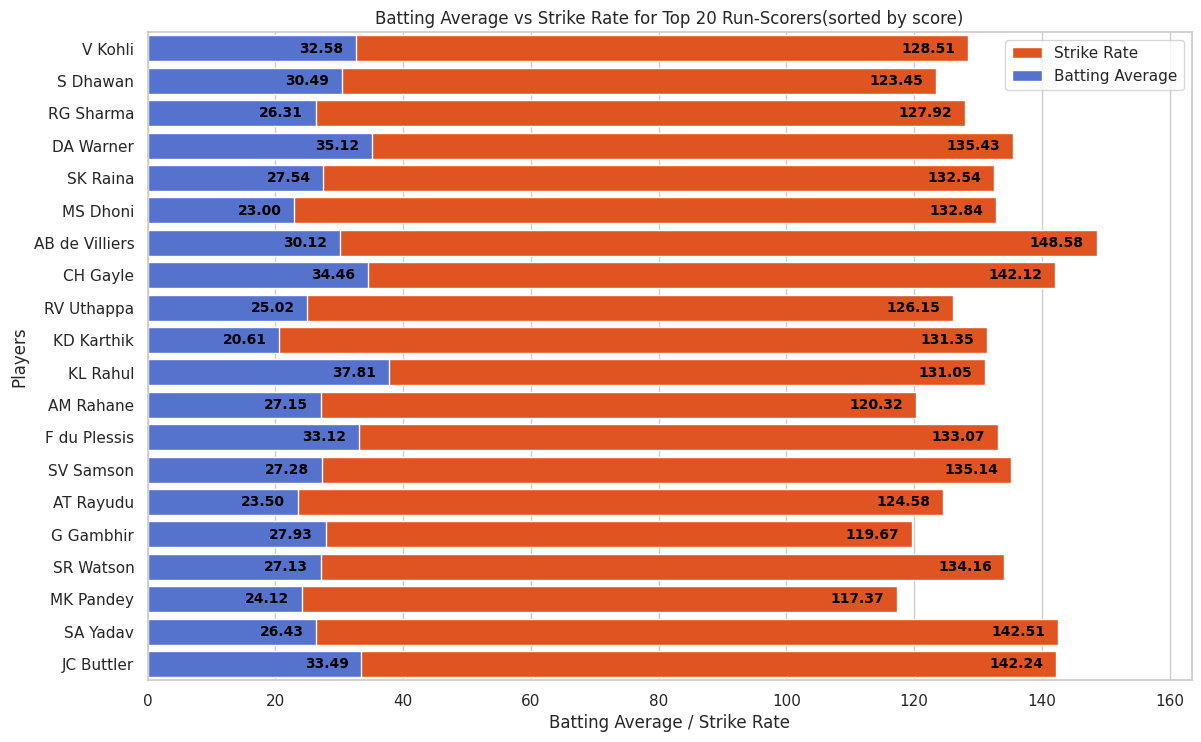

In [38]:
# Set up the figure
plt.figure(figsize=(12, 8))

ax2 = sns.barplot(data=df, y="batter", x="strike_rate", color="orangered", label="Strike Rate")
ax = sns.barplot(data=df, y="batter", x="batting_avg", color="royalblue", label="Batting Average")

# Get correct y-axis positions
y_positions = ax.get_yticks()

# Add labels above bars
for pos, (batter, batting_avg, strike_rate) in zip(y_positions, df[['batter', 'batting_avg', 'strike_rate']].values):
    ax.text(batting_avg -2, pos, f"{batting_avg:.2f}", 
            color="black", ha="right", va="center", fontsize=10, fontweight="bold")
    ax.text(strike_rate - 2, pos, f"{strike_rate:.2f}", 
            color="black", ha="right", va="center", fontsize=10, fontweight="bold")

# Labels and title
plt.xlabel("Batting Average / Strike Rate")
plt.ylabel("Players")
plt.title("Batting Average vs Strike Rate for Top 20 Run-Scorers(sorted by score)")
plt.xlim(0, max(df["batting_avg"].max(), df["strike_rate"].max()) * 1.1)  # Adjust x-axis limit for better spacing
plt.legend()

# Show plot
plt.show()


# Find Highest Average and Strike Rate for players with >50 matches

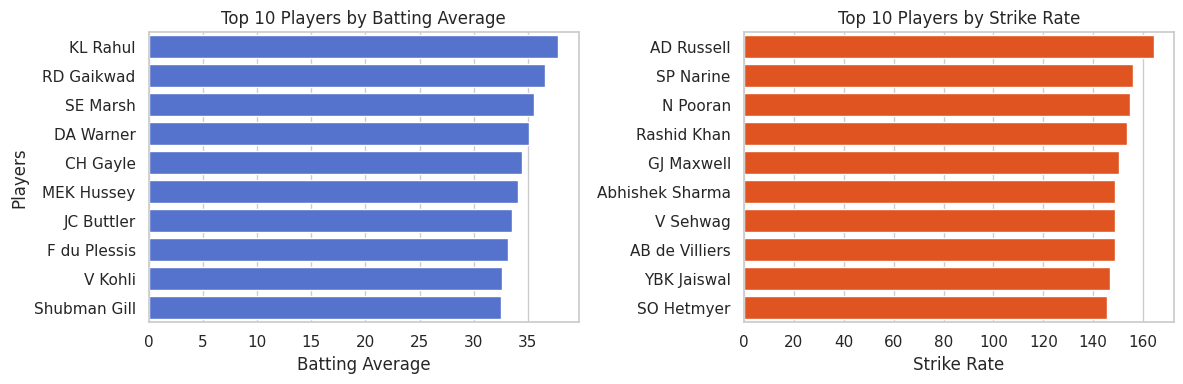

In [39]:
top_batsmen = batsman_stats.sort_values('batsman_runs', ascending=False)
top_batsmen = top_batsmen[top_batsmen['matches'] > 50]

# Get top 10 players by highest batting average and highest strike rate
top_avg = top_batsmen.nlargest(10, 'batting_avg')
top_sr = top_batsmen.nlargest(10, 'strike_rate')

# Set up the figure
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot top 10 batting averages
sns.barplot(data=top_avg, y="batter", x="batting_avg", ax=axes[0], color="royalblue")
axes[0].set_xlabel("Batting Average")
axes[0].set_ylabel("Players")
axes[0].set_title("Top 10 Players by Batting Average")

# Plot top 10 strike rates
sns.barplot(data=top_sr, y="batter", x="strike_rate", ax=axes[1], color="orangered")
axes[1].set_xlabel("Strike Rate")
axes[1].set_ylabel("")  # Remove y-axis label for clarity
axes[1].set_title("Top 10 Players by Strike Rate")

# Adjust layout
plt.tight_layout()
plt.show()

# Plot top wicket-takers

In [40]:
# 2. Top Wicket Takers
# First, identify rows where a wicket fell and it's attributed to the bowler
bowler_wickets = deliveries[deliveries['is_wicket'] == 1].copy()
valid_dismissal_types = ['bowled', 'caught', 'lbw', 'stumped', 'caught and bowled', 'hit wicket']
bowler_wickets = bowler_wickets[bowler_wickets['dismissal_kind'].isin(valid_dismissal_types)]

# Count wickets
bowler_wicket_counts = bowler_wickets.groupby('bowler').size().reset_index()
bowler_wicket_counts.columns = ['bowler', 'wickets']

# Calculate economy rate
bowler_runs = deliveries.groupby('bowler')['total_runs'].sum().reset_index()
bowler_balls = deliveries.groupby('bowler').size().reset_index()
bowler_balls.columns = ['bowler', 'balls_bowled']

bowler_stats = pd.merge(bowler_wicket_counts, bowler_runs, on='bowler', how='outer')
bowler_stats = pd.merge(bowler_stats, bowler_balls, on='bowler', how='left')
bowler_stats.fillna(0, inplace=True)

bowler_stats['economy'] = (bowler_stats['total_runs'] / (bowler_stats['balls_bowled'] / 6)).round(2)
bowler_stats['bowling_avg'] = (bowler_stats['total_runs'] / bowler_stats['wickets']).round(2)
bowler_stats['bowling_avg'].replace([np.inf, -np.inf], 0, inplace=True)

top_bowlers = bowler_stats.sort_values('wickets', ascending=False).head(20)
print("\nTop 20 Wicket Takers:")
top_bowlers[['bowler', 'wickets', 'economy', 'bowling_avg']]


Top 20 Wicket Takers:


,bowler,wickets,economy,bowling_avg
524,YS Chahal,205.0,7.74,22.83
348,PP Chawla,192.0,7.98,26.97
119,DJ Bravo,183.0,8.08,24.24
71,B Kumar,181.0,7.46,27.91
355,R Ashwin,180.0,6.97,30.19
446,SP Narine,180.0,6.76,25.96
8,A Mishra,174.0,7.30,24.10
438,SL Malinga,170.0,7.03,20.51
193,JJ Bumrah,168.0,7.23,22.86
373,RA Jadeja,160.0,7.57,30.73


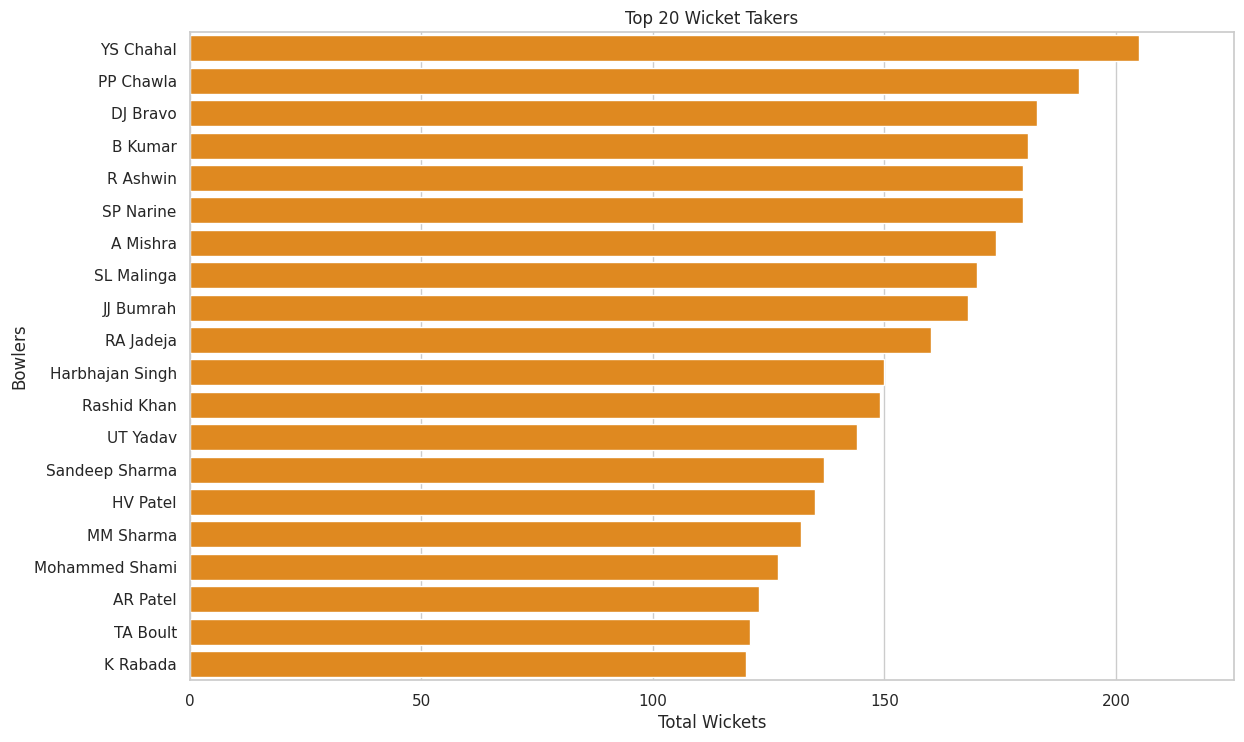

In [41]:
df = top_bowlers[['bowler', 'wickets', 'economy', 'bowling_avg']]
plt.figure(figsize=(12, 8))
sns.barplot(data=df, y="bowler", x="wickets", color="darkorange")

# Labels and title
plt.xlabel("Total Wickets")
plt.ylabel("Bowlers")
plt.title("Top 20 Wicket Takers")
plt.xlim(0, df["wickets"].max() * 1.1)  # Adjust x-axis limit for better spacing

# Show plot
plt.show()


# Plot top highest individual scores

In [42]:
# Group by batter and match_id to get runs per match
top_scores_per_match = deliveries.groupby(['batter', 'match_id'])['batsman_runs'].sum().reset_index()

# Get the highest score for each player
top_individual_scores = top_scores_per_match.groupby('batter')['batsman_runs'].max().reset_index()

# Rename column for clarity
top_individual_scores.columns = ['batter', 'highest_individual_score']

# Sort by highest individual score
top_individual_scores = top_individual_scores.sort_values(by='highest_individual_score', ascending=False)

print("\nTop Individual Scores by Players:")
print(top_individual_scores.head(10))  # Display top 20



Top Individual Scores by Players:
             batter  highest_individual_score
124        CH Gayle                       175
102     BB McCullum                       158
449       Q de Kock                       140
30   AB de Villiers                       133
289        KL Rahul                       132
592    Shubman Gill                       129
490         RR Pant                       128
340         M Vijay                       127
147       DA Warner                       126
242      JC Buttler                       124


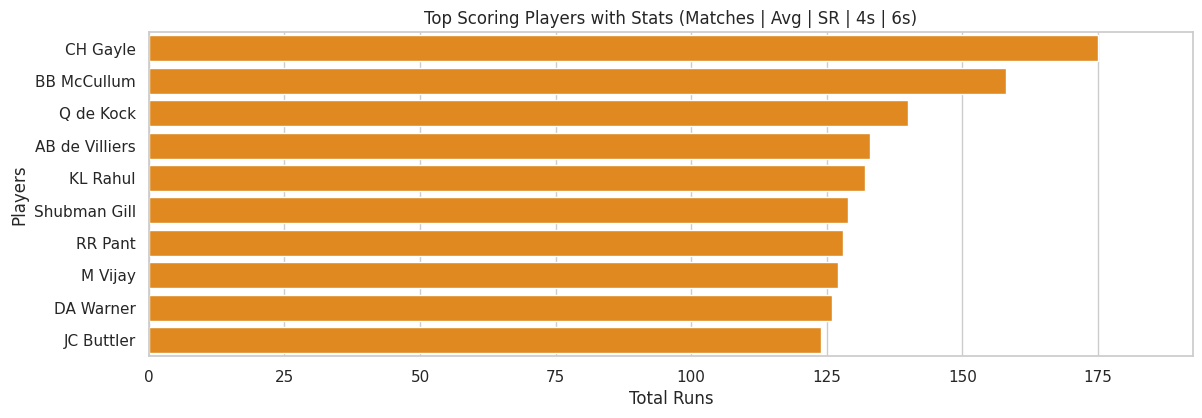

In [43]:
# Sort DataFrame by Total Runs
df = top_individual_scores.head(10)

# Set up the figure
plt.figure(figsize=(12, 4))
ax = sns.barplot(data=df, y="batter", x="highest_individual_score", color="darkorange")


# Labels and title
plt.xlabel("Total Runs")
plt.ylabel("Players")
plt.title("Top Scoring Players with Stats (Matches | Avg | SR | 4s | 6s)")
plt.xlim(0, df["highest_individual_score"].max() * 1.1)  # Adjust x-axis limit for better spacing

# Show plot
plt.show()

# Man of the Match Count Analysis

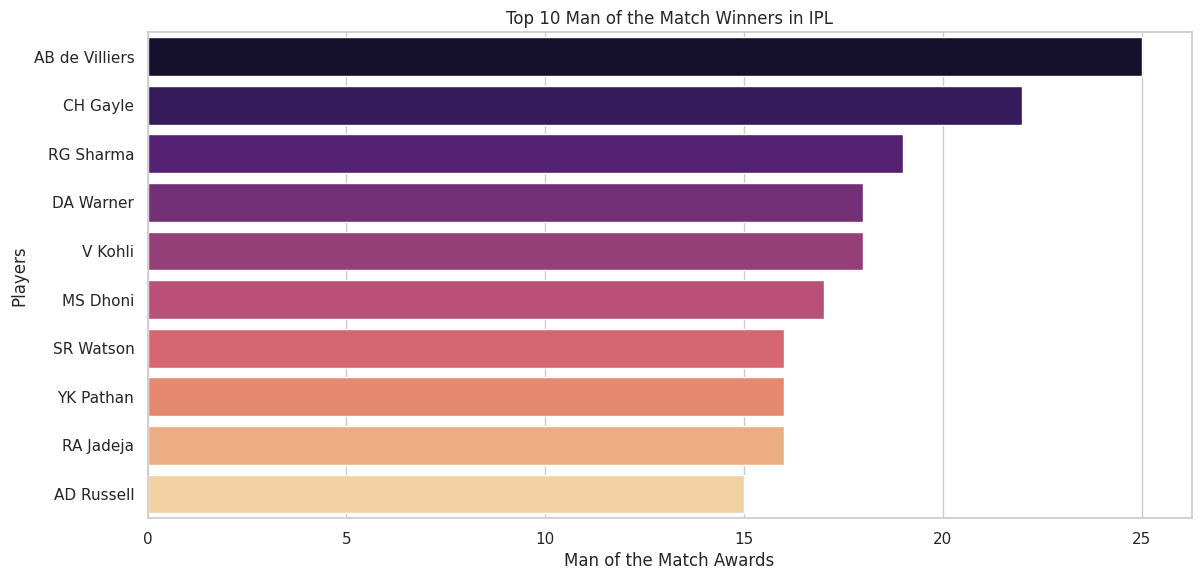

In [44]:
# Count MoM awards
mom_counts = matches['player_of_match'].value_counts().reset_index()
mom_counts.columns = ['player', 'mom_count']

# Get the Top 10 MoM Winners
top_mom_winners = mom_counts.head(10)

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(data=top_mom_winners, y='player', x='mom_count', palette='magma')

# Labels and title
plt.xlabel("Man of the Match Awards")
plt.ylabel("Players")
plt.title("Top 10 Man of the Match Winners in IPL")
plt.show()

# Use K-Means Clustering to plot Batting Average vs Bowling Economy Rate for number of clusters = 3 (Batsman, Bowler, All Rounder)

In [45]:
# 4. Batting and Bowling Clusters using K-Means
# Combine batting and bowling stats
player_combined = pd.merge(batsman_stats, bowler_stats, left_on='batter', right_on='bowler', how='outer')
player_combined.fillna(0, inplace=True)


# Select players with at least 10 matches
min_matches = 10
filtered_players = player_combined[(player_combined['matches'] >= min_matches) | (player_combined['matches'] == 0)].copy()

# Prepare data for clustering
# Replace infinite values with NaN
filtered_players[['batting_avg', 'economy']] = filtered_players[['batting_avg', 'economy']].replace([np.inf, -np.inf], np.nan)
# Drop rows with NaN in the clustering features
filtered_players_clean = filtered_players.dropna(subset=['batting_avg', 'economy'])

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(filtered_players_clean[['batting_avg', 'economy']])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Add clusters back to the clean dataframe
filtered_players_clean['cluster'] = clusters

print("\nPlayer Clusters based on Batting Average and Bowling Economy:")
filtered_players_clean.groupby('cluster')[['batting_avg', 'economy']].mean()


Player Clusters based on Batting Average and Bowling Economy:


,batting_avg,economy
cluster,,
0,22.092062,0.036082
1,4.281656,8.578405
2,20.811207,9.142845


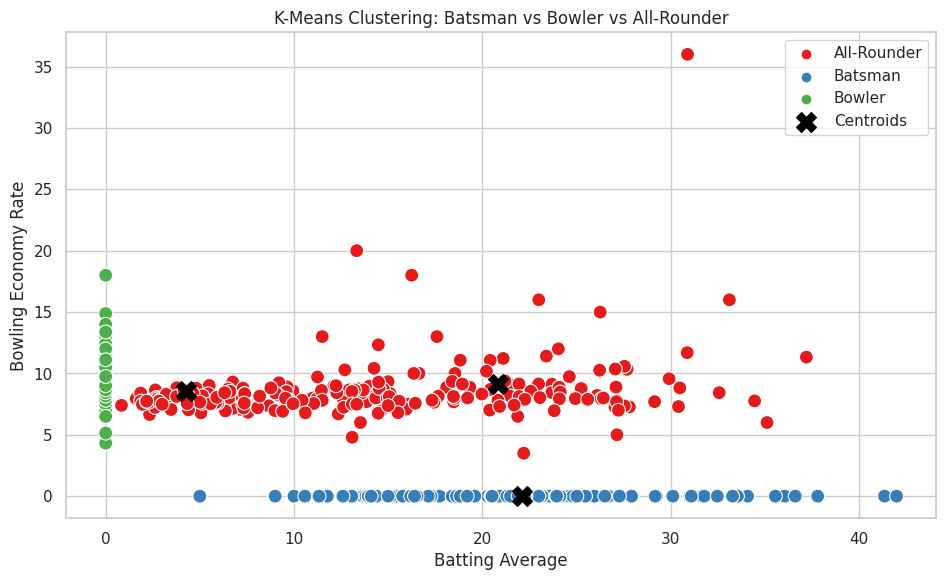

In [46]:
def assign_role(row):
    if row['bowler'] == 0:
        return 'Batsman'
    elif row['batter'] == 0:
        return 'Bowler'
    else:
        return 'All-Rounder'

filtered_players_clean['Role'] = filtered_players_clean.apply(assign_role, axis=1)

# Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_players_clean, x='batting_avg', y='economy', hue='Role', palette='Set1', s=100)

# Plot Cluster Centers
centers = scaler.inverse_transform(kmeans.cluster_centers_)  # Convert back to original scale
plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='X', s=200, label="Centroids")

# Labels and Title
plt.xlabel("Batting Average")
plt.ylabel("Bowling Economy Rate")
plt.title("K-Means Clustering: Batsman vs Bowler vs All-Rounder")
plt.legend()
plt.show()

# dentify Top 10 Batsmen in each run category:

In [47]:
# 5. Top Players in Different Run Categories
top_ones = deliveries[deliveries['batsman_runs'] == 1].groupby('batter').size().reset_index()
top_ones.columns = ['batter', 'singles']
top_ones = top_ones.sort_values('singles', ascending=False).head(10).reset_index(drop=True)

top_twos = deliveries[deliveries['batsman_runs'] == 2].groupby('batter').size().reset_index()
top_twos.columns = ['batter', 'doubles']
top_twos = top_twos.sort_values('doubles', ascending=False).head(10).reset_index(drop=True)

top_fours = deliveries[deliveries['batsman_runs'] == 4].groupby('batter').size().reset_index()
top_fours.columns = ['batter', 'fours']
top_fours = top_fours.sort_values('fours', ascending=False).head(10).reset_index(drop=True)

top_sixes = deliveries[deliveries['batsman_runs'] == 6].groupby('batter').size().reset_index()
top_sixes.columns = ['batter', 'sixes']
top_sixes = top_sixes.sort_values('sixes', ascending=False).head(10).reset_index(drop=True)



In [48]:
print("\nTop 10 Singles Scorers:")
print(top_ones)

print("\nTop 10 Doubles Scorers:")
print(top_twos)

print("\nTop 10 Fours Hitters:")
print(top_fours)

print("\nTop 10 Sixes Hitters:")
print(top_sixes)


Top 10 Singles Scorers:
       batter  singles
0     V Kohli     2591
1    S Dhawan     2102
2   RG Sharma     1996
3    SK Raina     1708
4   DA Warner     1682
5    MS Dhoni     1554
6   AM Rahane     1537
7   AT Rayudu     1495
8    KL Rahul     1464
9  KD Karthik     1464

Top 10 Doubles Scorers:
           batter  doubles
0         V Kohli      445
1       DA Warner      370
2        MS Dhoni      340
3        S Dhawan      299
4        SK Raina      271
5  AB de Villiers      268
6       RG Sharma      263
7      KD Karthik      258
8       AM Rahane      257
9       G Gambhir      249

Top 10 Fours Hitters:
         batter  fours
0      S Dhawan    768
1       V Kohli    708
2     DA Warner    663
3     RG Sharma    599
4      SK Raina    506
5     G Gambhir    492
6    RV Uthappa    481
7     AM Rahane    479
8    KD Karthik    466
9  F du Plessis    422

Top 10 Sixes Hitters:
           batter  sixes
0        CH Gayle    359
1       RG Sharma    281
2         V Kohli    273
3

In [49]:
# Seasonal Analysis
# ================

# 1. Average Runs per Match per Season
match_runs = deliveries.groupby('match_id')['total_runs'].sum().reset_index()
match_runs = pd.merge(match_runs, matches[['id', 'season']], left_on='match_id', right_on='id', how='left')
season_avg_runs = match_runs.groupby('season')['total_runs'].mean().reset_index()
season_avg_runs.columns = ['season', 'avg_runs_per_match']
season_avg_runs['avg_runs_per_match'] = season_avg_runs['avg_runs_per_match'].round(2)
season_avg_runs['season'] = season_avg_runs['season'].astype(int)
print("\nAverage Runs per Match per Season:")
season_avg_runs


Average Runs per Match per Season:


,season,avg_runs_per_match
0,2008,309.26
1,2009,286.89
2,2010,314.72
3,2011,293.03
4,2012,303.42
5,2013,297.39
6,2014,315.52
7,2015,315.16
8,2016,314.37
9,2017,318.41


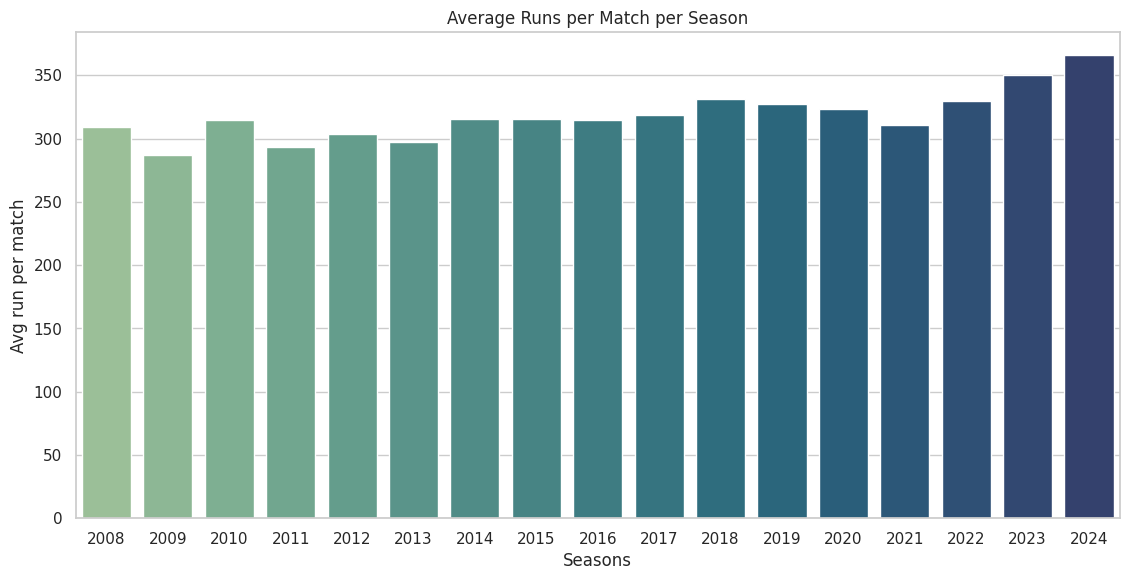

In [50]:
plt.figure(figsize=(12,6))
sns.barplot(data = season_avg_runs, x = 'season', y = 'avg_runs_per_match', palette = 'crest') 

plt.xlabel("Seasons")
plt.ylabel("Avg run per match")
plt.title('Average Runs per Match per Season')
plt.show()

# Identify targets of 200+ runs per season

In [51]:
# 2. 200+ Targets per Season
high_scoring_innings = match_scores[match_scores['total_runs'] >= 200]
high_scoring_innings = pd.merge(high_scoring_innings, matches[['id', 'season']], left_on='match_id', right_on='id', how='left')
high_scores_per_season = high_scoring_innings.groupby('season').size().reset_index()
high_scores_per_season.columns = ['season', '200+_scores']
print("\n200+ Scores per Season:")
high_scores_per_season


200+ Scores per Season:


,season,200+_scores
0,2008.0,11
1,2009.0,1
2,2010.0,9
3,2011.0,5
4,2012.0,5
5,2013.0,4
6,2014.0,9
7,2015.0,6
8,2016.0,6
9,2017.0,10


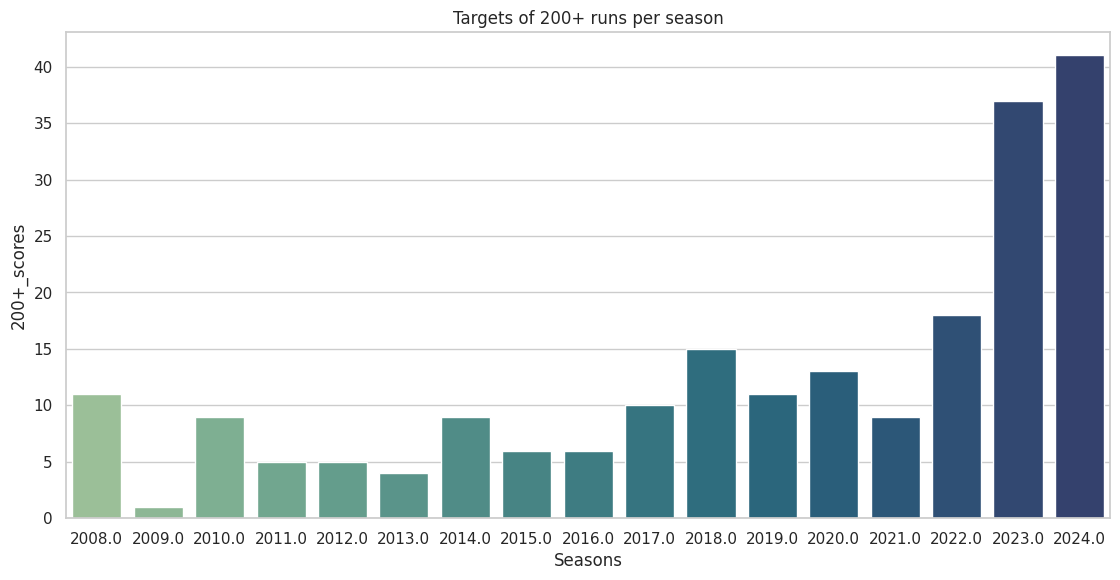

In [52]:
plt.figure(figsize=(12,6))
sns.barplot(data = high_scores_per_season, x = 'season', y = '200+_scores', palette = 'crest') 

plt.xlabel("Seasons")
plt.ylabel("200+_scores")
plt.title('Targets of 200+ runs per season')
plt.show()

# Find the average score of each team per season

In [53]:
# 3. Team Performance by Season
team_season_runs = deliveries.groupby(['batting_team', 'match_id'])['total_runs'].sum().reset_index()
team_season_runs = pd.merge(team_season_runs, matches[['id', 'season']], left_on='match_id', right_on='id', how='left')
team_season_avg = team_season_runs.groupby(['season', 'batting_team'])['total_runs'].mean().reset_index()
team_season_avg.columns = ['season', 'team', 'avg_score']
team_season_avg['avg_score'] = team_season_avg['avg_score'].round(2)
team_season_avg['season'] = team_season_avg['season'].astype(int)
print("\nAverage Team Score per Season (Sample):")
team_season_avg.head(10)


Average Team Score per Season (Sample):


,season,team,avg_score
0,2008,Chennai Super Kings,157.50
1,2008,Delhi Capitals,151.29
2,2008,Kings XI Punjab,164.27
3,2008,Kolkata Knight Riders,149.38
4,2008,Mumbai Indians,148.57
5,2008,Rajasthan Royals,162.56
6,2008,Royal Challengers Bangalore,141.64
7,2008,Sunrisers Hyderabad,159.21
8,2009,Chennai Super Kings,159.36
9,2009,Delhi Capitals,142.07


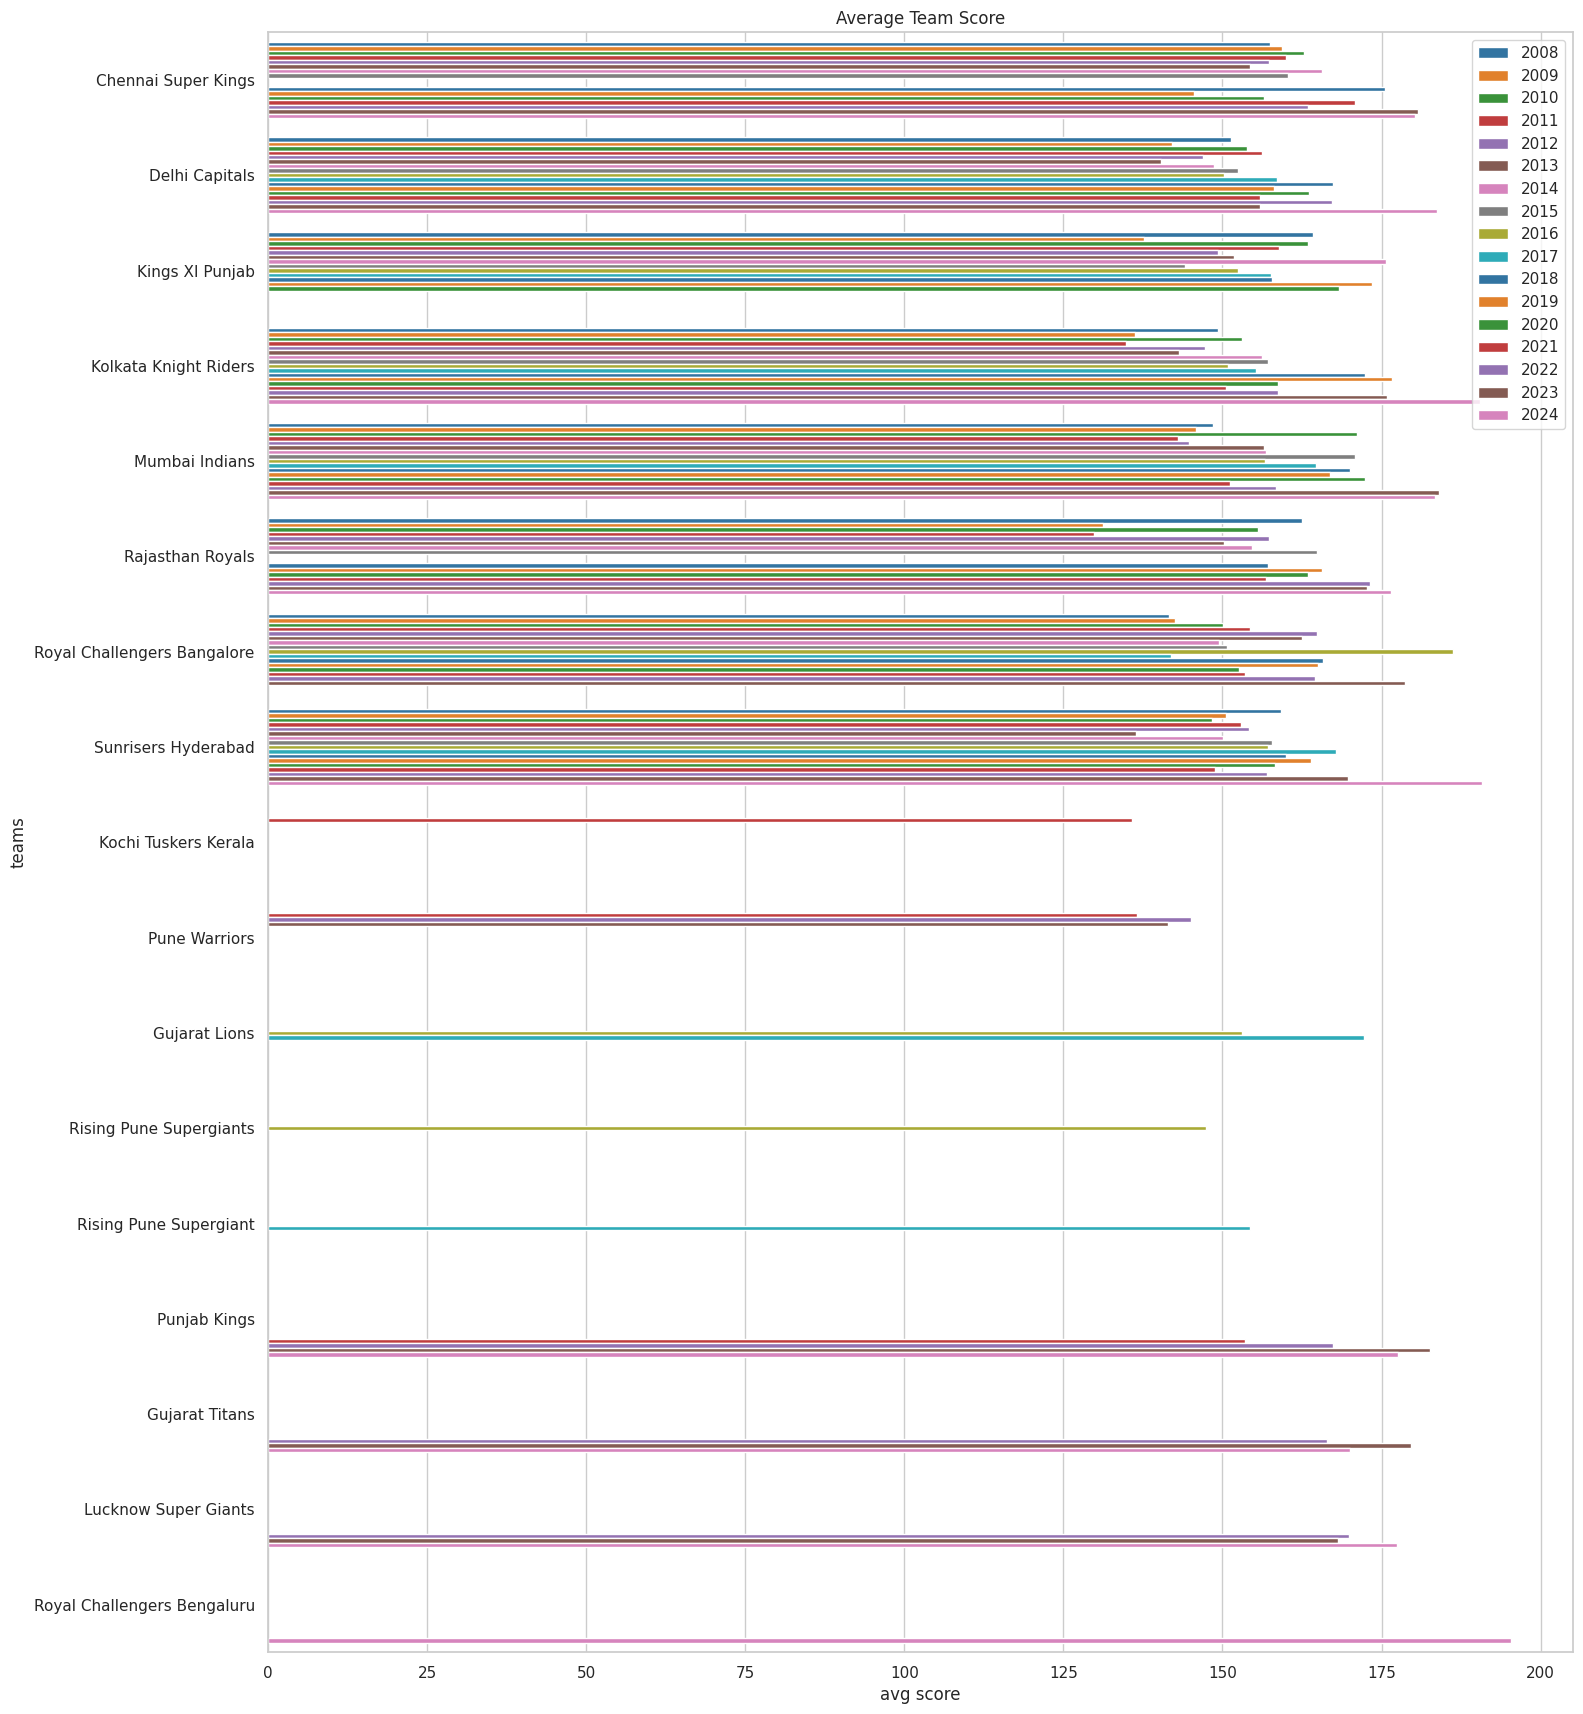

In [54]:
plt.figure(figsize=(15, 20))
sns.barplot(data = team_season_avg, x = 'avg_score', y = 'team',hue="season" , palette='tab10') 

plt.xlabel("avg score")
plt.ylabel("teams")
plt.title('Average Team Score')
plt.legend()
plt.show()

# Analyze runs of Orange Cap Holders per season

In [55]:

season_runs = deliveries.merge(matches[['id', 'season']], left_on='match_id', right_on='id', how='left')
orange_cap = season_runs.groupby(['season', 'batter'])['batsman_runs'].sum().reset_index()
orange_cap = orange_cap.loc[orange_cap.groupby('season')['batsman_runs'].idxmax()]
orange_cap.columns = ['season', 'batter', 'total_runs']
orange_cap['season'] = orange_cap['season'].astype(int)
orange_cap


,season,batter,total_runs
115,2008,SE Marsh,616
229,2009,ML Hayden,572
446,2010,SR Tendulkar,618
502,2011,CH Gayle,608
684,2012,CH Gayle,733
910,2013,MEK Hussey,733
1088,2014,RV Uthappa,660
1148,2015,DA Warner,562
1383,2016,V Kohli,973
1422,2017,DA Warner,641


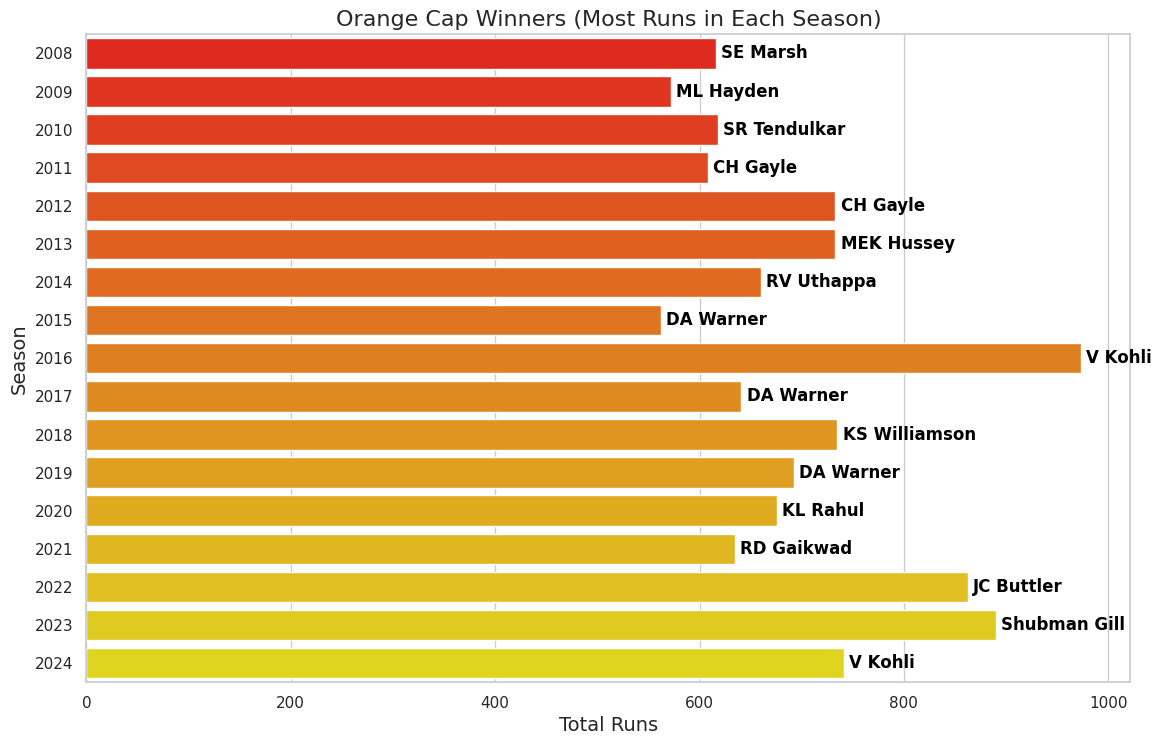

In [56]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=orange_cap, y='season', x='total_runs', palette='autumn', orient='h')

# Annotate each bar with the player's name
for bar, (season, batter, total_runs) in zip(ax.patches, orange_cap[['season', 'batter', 'total_runs']].values):
    ax.text(bar.get_width() + 5,  # Slightly outside the bar
            bar.get_y() + bar.get_height() / 2,  # Center vertically
            f"{batter}", 
            color='black', ha='left', va='center', fontsize=12, fontweight='bold')

plt.xlabel("Total Runs", fontsize=14)
plt.ylabel("Season", fontsize=14)
plt.title('Orange Cap Winners (Most Runs in Each Season)', fontsize=16)
plt.show()

# Track wickets of Purple Cap Holders per season

In [57]:
# Filter out only wicket-taking deliveries
wicket_deliveries = deliveries[deliveries['is_wicket'] == 1]

# Merge with season data
season_wickets = wicket_deliveries.merge(matches[['id', 'season']], left_on='match_id', right_on='id', how='left')

# Count wickets per bowler per season
purple_cap = season_wickets.groupby(['season', 'bowler'])['is_wicket'].count().reset_index()

# Find top wicket-taker (Purple Cap holder) per season
purple_cap = purple_cap.loc[purple_cap.groupby('season')['is_wicket'].idxmax()]

# Rename columns
purple_cap.columns = ['season', 'bowler', 'total_wickets']
purple_cap['season'] = purple_cap['season'].astype(int)

# Display Purple Cap winners
print(purple_cap)


      season         bowler  total_wickets
77      2008  Sohail Tanvir             24
157     2009       RP Singh             26
248     2010        PP Ojha             22
374     2011     SL Malinga             30
445     2012       M Morkel             30
517     2013       DJ Bravo             34
648     2014      MM Sharma             26
706     2015       DJ Bravo             28
789     2016        B Kumar             24
877     2017        B Kumar             28
960     2018         AJ Tye             28
1075    2019       K Rabada             29
1159    2020       K Rabada             32
1230    2021       HV Patel             35
1400    2022      YS Chahal             29
1467    2023      MM Sharma             31
1540    2024       HV Patel             30


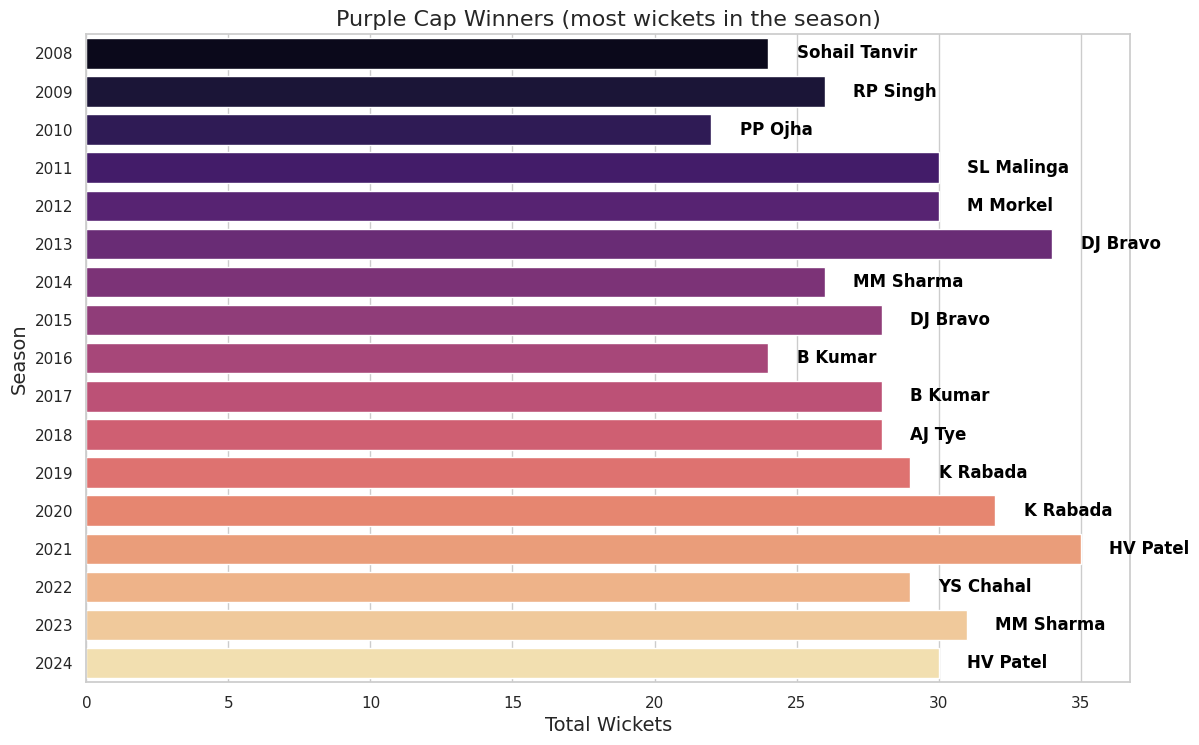

In [58]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=purple_cap, y='season', x='total_wickets', palette='magma', orient='h')

# Annotate each bar with the player's name
for bar, (season, bowler, total_wickets) in zip(ax.patches, purple_cap[['season', 'bowler', 'total_wickets']].values):
    ax.text(bar.get_width() + 1,  # Slightly outside the bar
            bar.get_y() + bar.get_height() / 2,  # Center vertically
            f"{bowler}", 
            color='black', ha='left', va='center', fontsize=12, fontweight='bold')

plt.xlabel("Total Wickets", fontsize=14)
plt.ylabel("Season", fontsize=14)
plt.title('Purple Cap Winners (most wickets in the season)', fontsize=16)
plt.show()

# Find top 10 bowlers per season

In [59]:
# Count total wickets per bowler per season
top_bowlers = season_wickets.groupby(['season', 'bowler'])['is_wicket'].count().reset_index()

# Rename columns
top_bowlers.columns = ['season', 'bowler', 'total_wickets']

# Rank bowlers within each season
top_bowlers['rank'] = top_bowlers.groupby('season')['total_wickets'].rank(ascending=False, method='first')

# Filter top 10 bowlers per season
top_10_bowlers = top_bowlers[top_bowlers['rank'] <= 10].sort_values(['season', 'rank'])
top_10_bowlers['season'] = top_10_bowlers['season'].astype(int)
# Display top 10 bowlers per season
top_10_bowlers


,season,bowler,total_wickets,rank
77,2008,Sohail Tanvir,24,1.0
30,2008,IK Pathan,20,2.0
32,2008,JA Morkel,20,3.0
70,2008,SK Warne,20,4.0
72,2008,SR Watson,20,5.0
...,...,...,...,...
1528,2024,Arshdeep Singh,20,6.0
1542,2024,Harshit Rana,20,7.0
1564,2024,MA Starc,20,8.0
1608,2024,T Natarajan,20,9.0


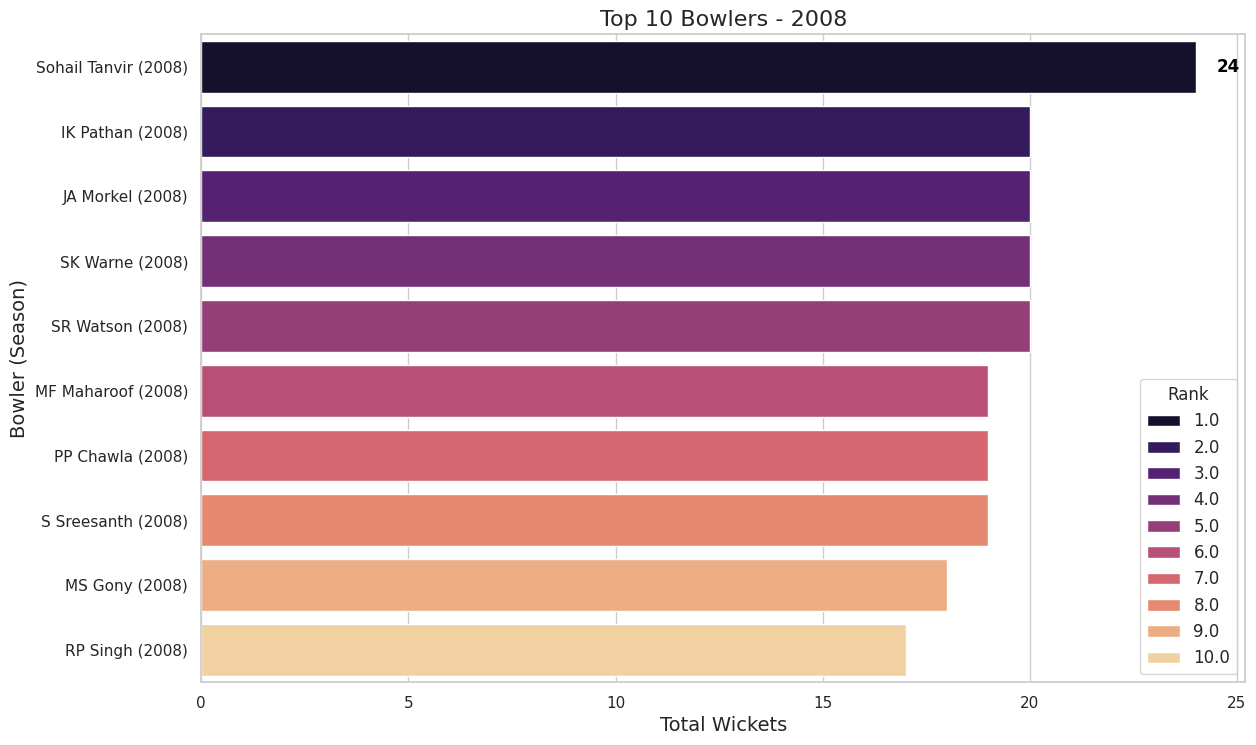

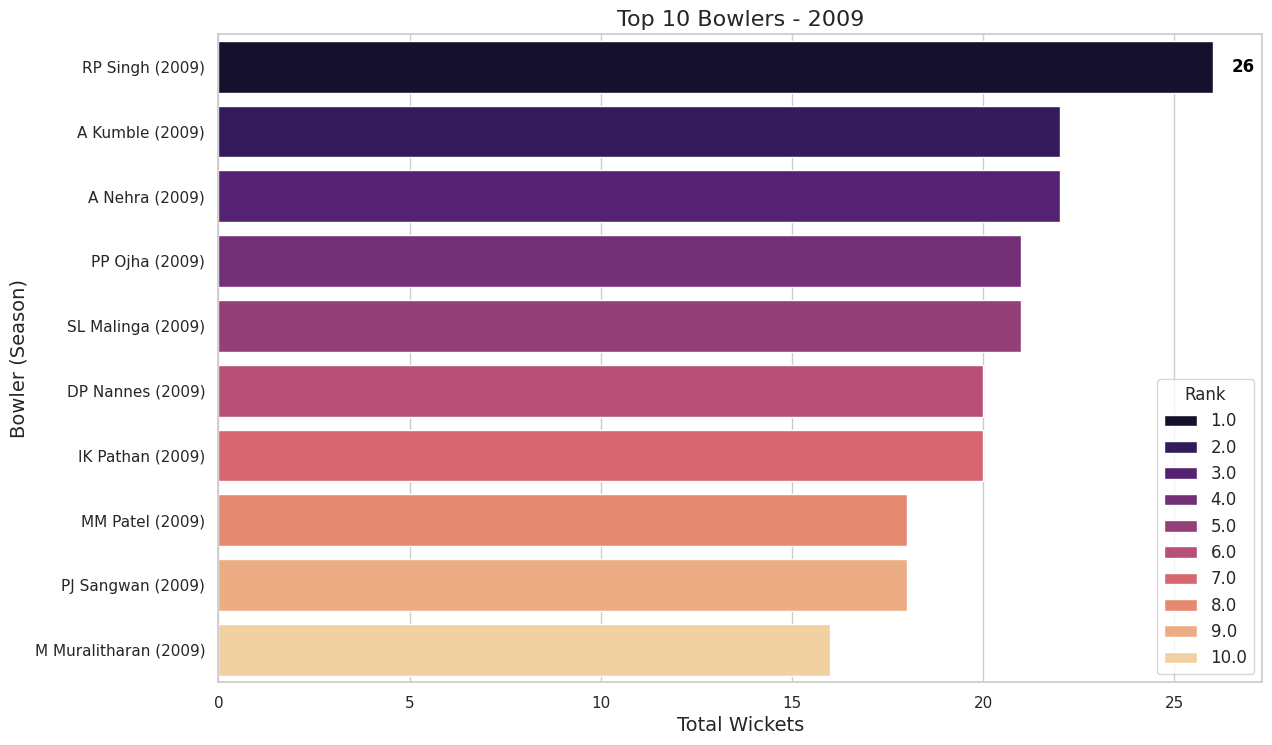

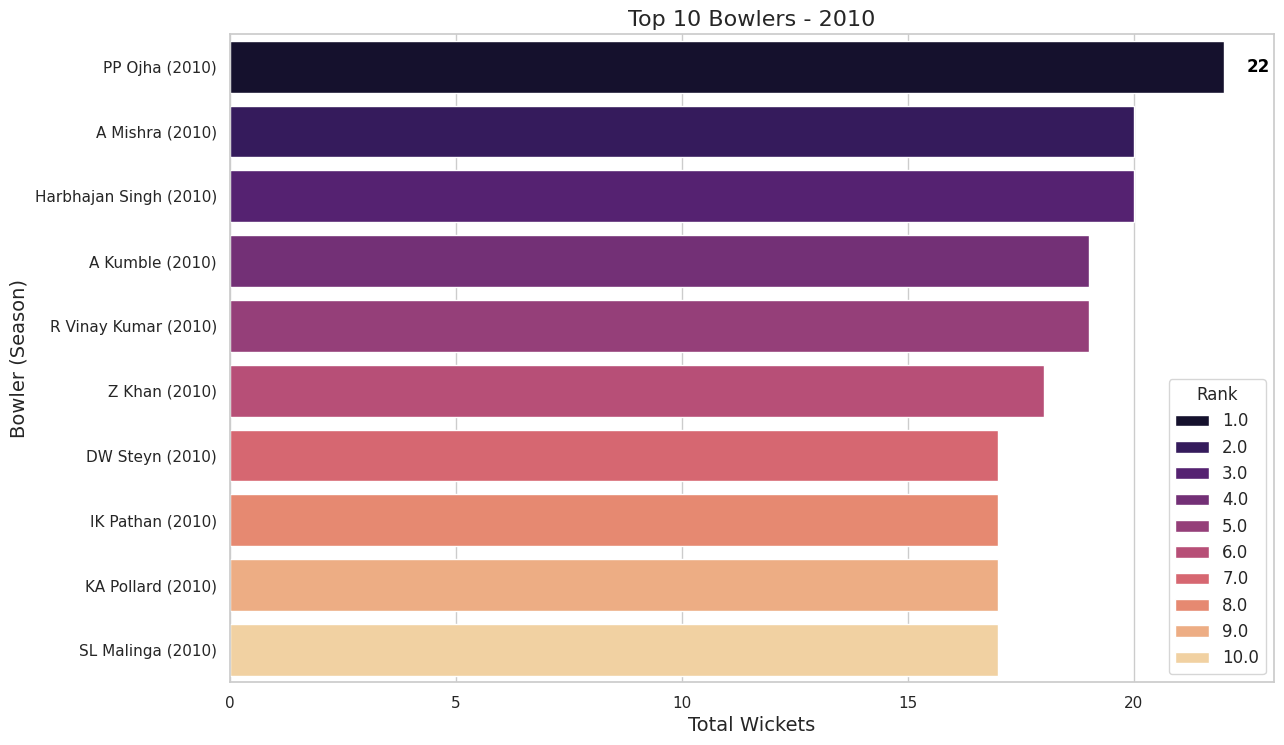

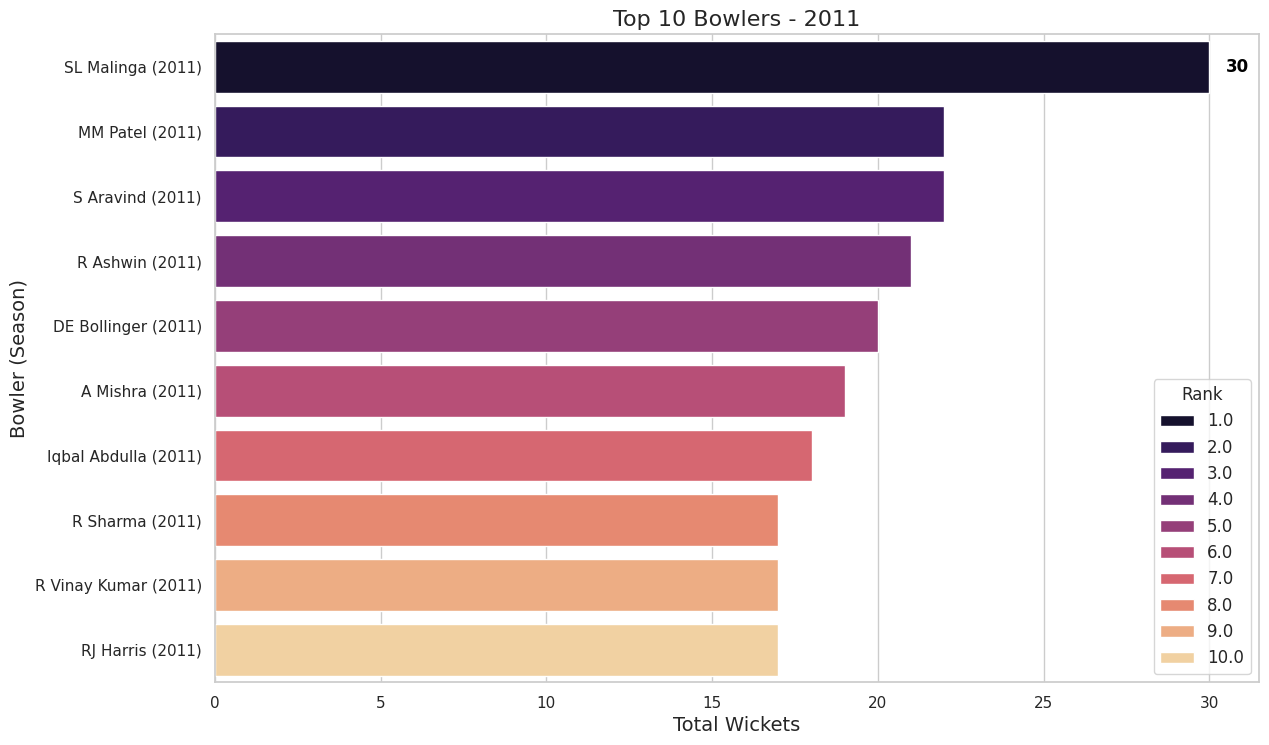

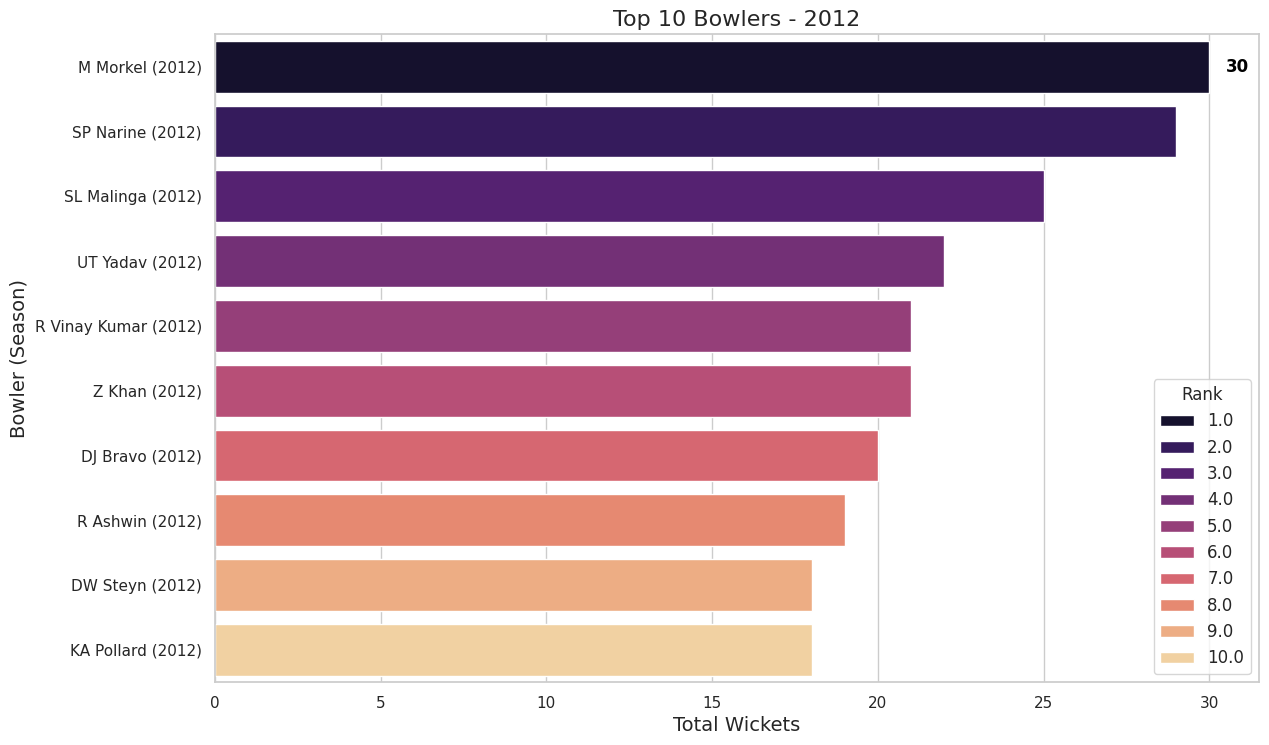

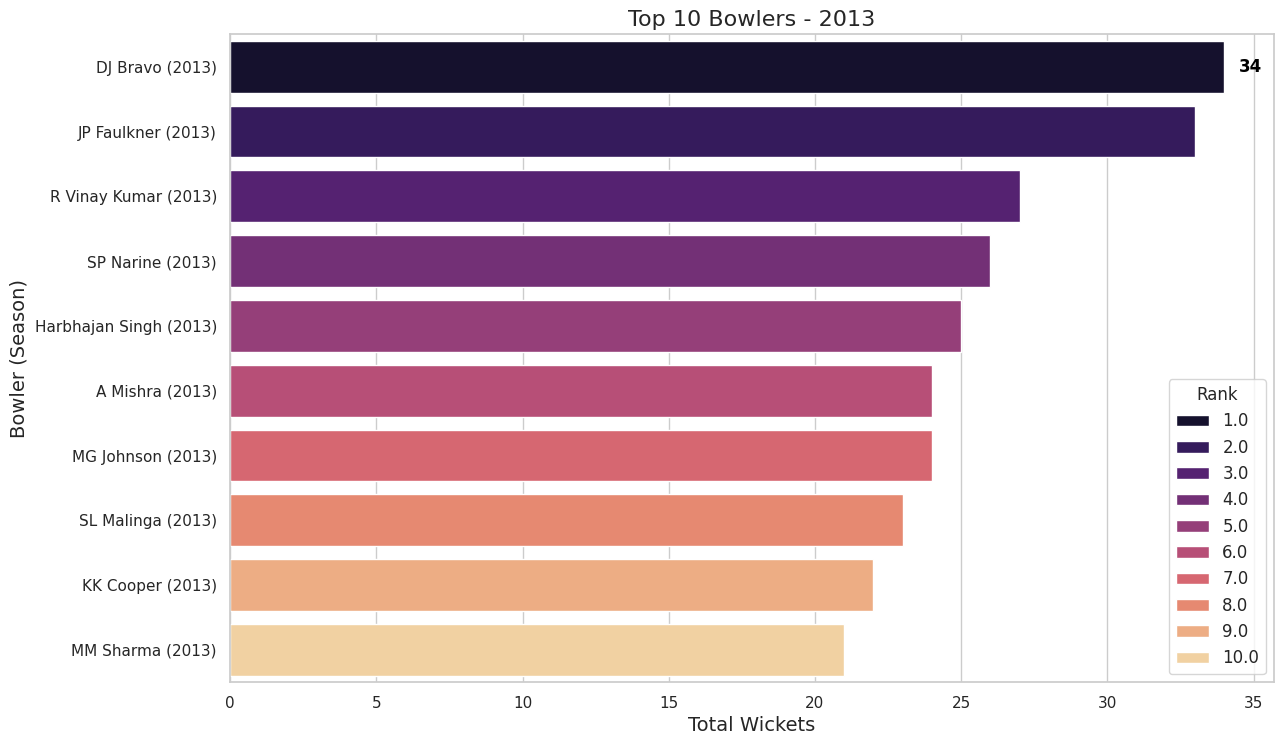

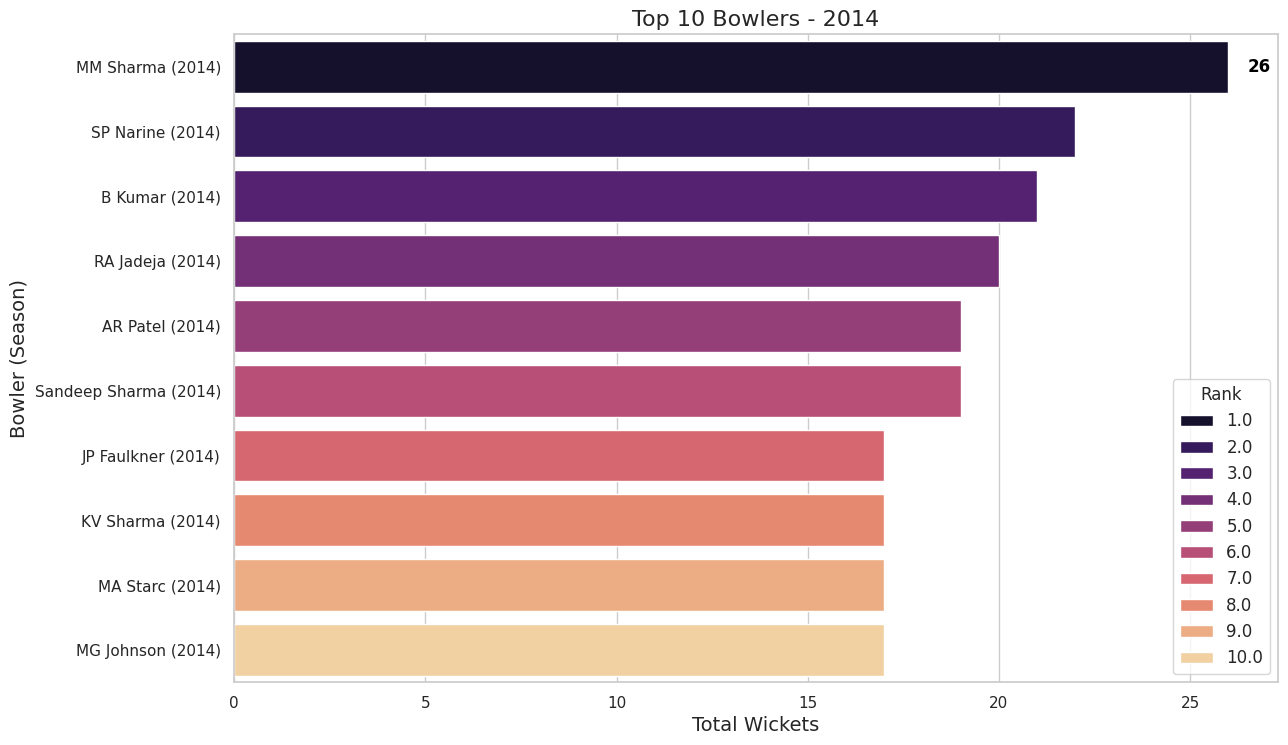

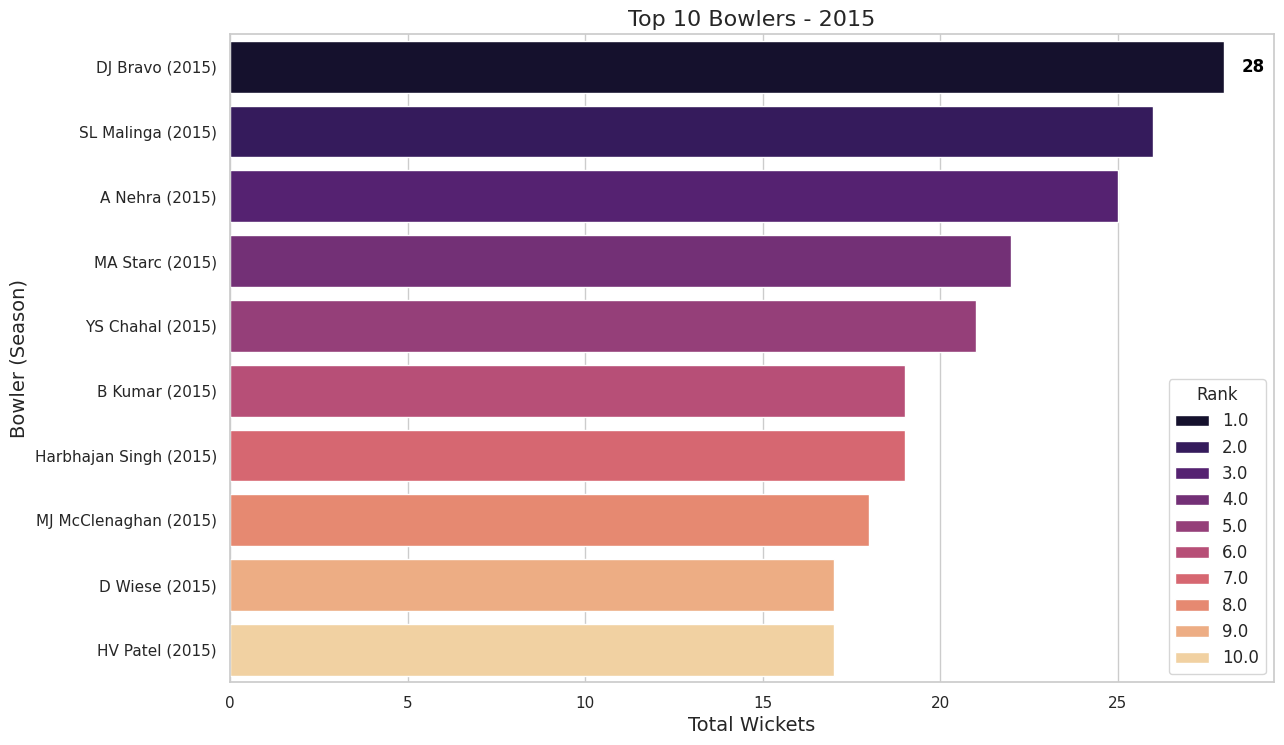

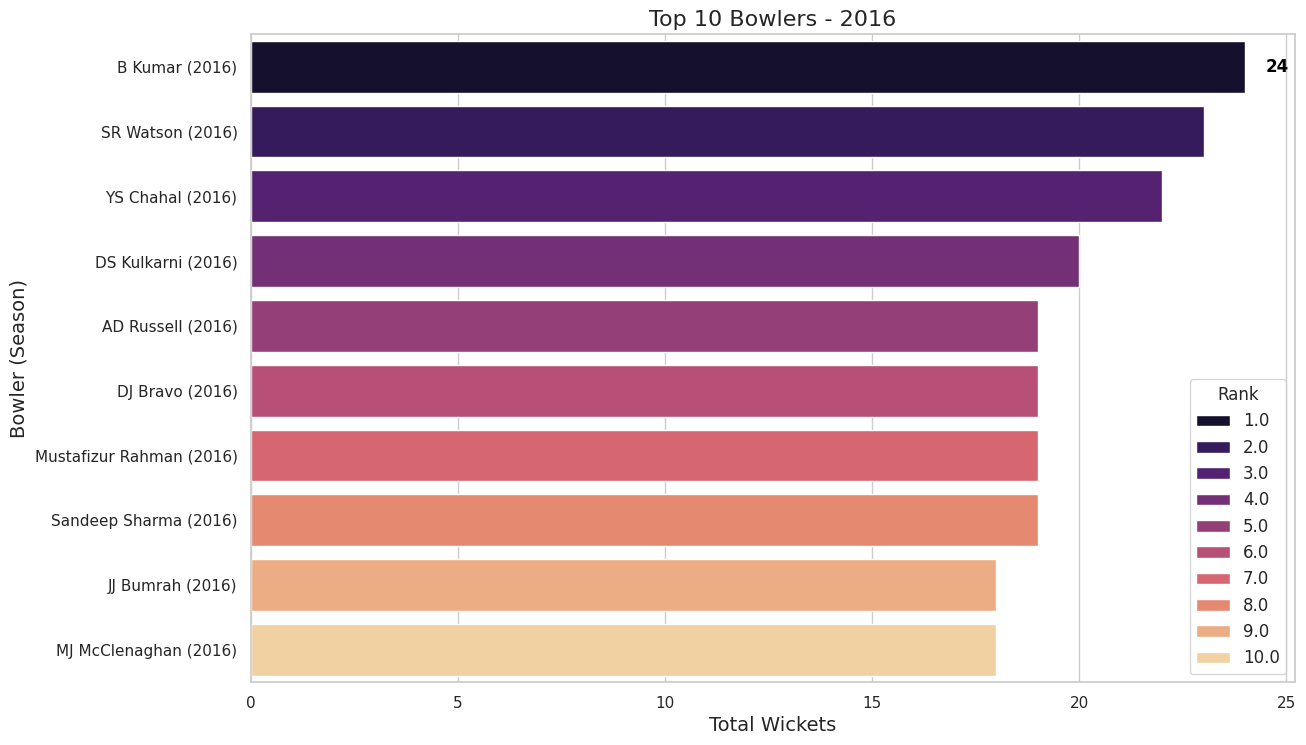

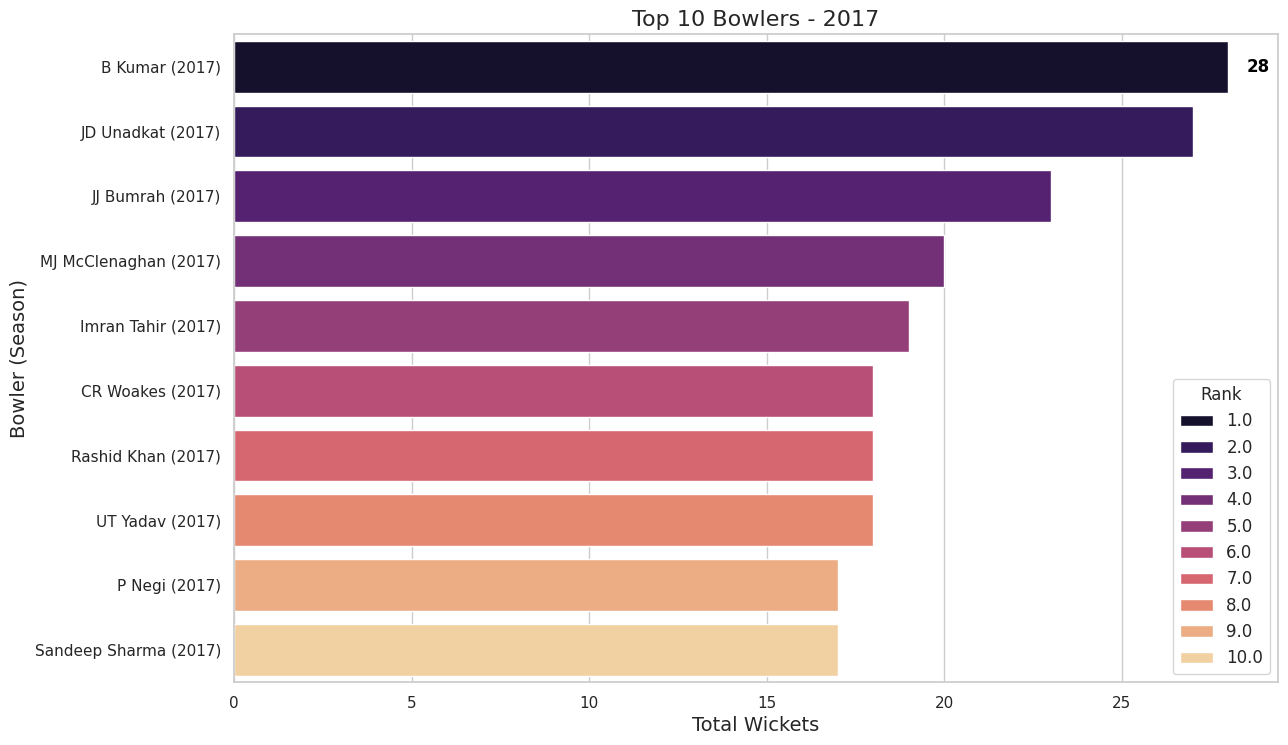

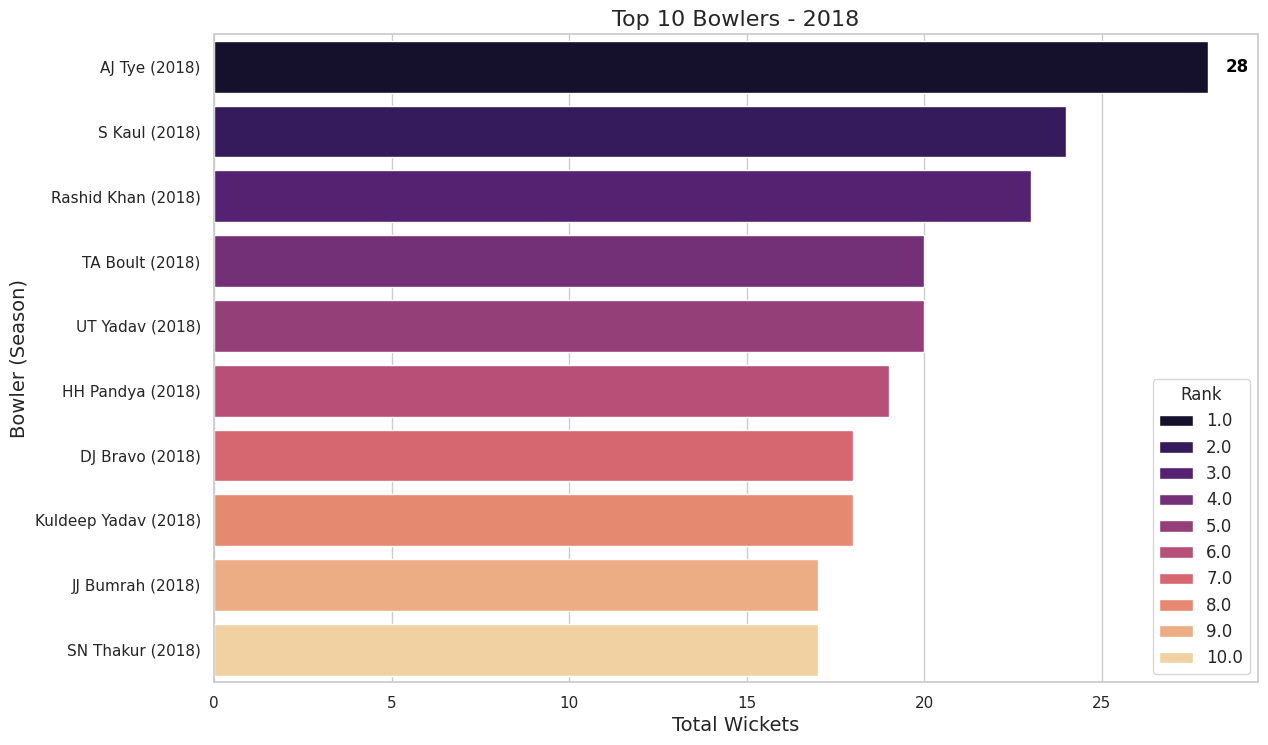

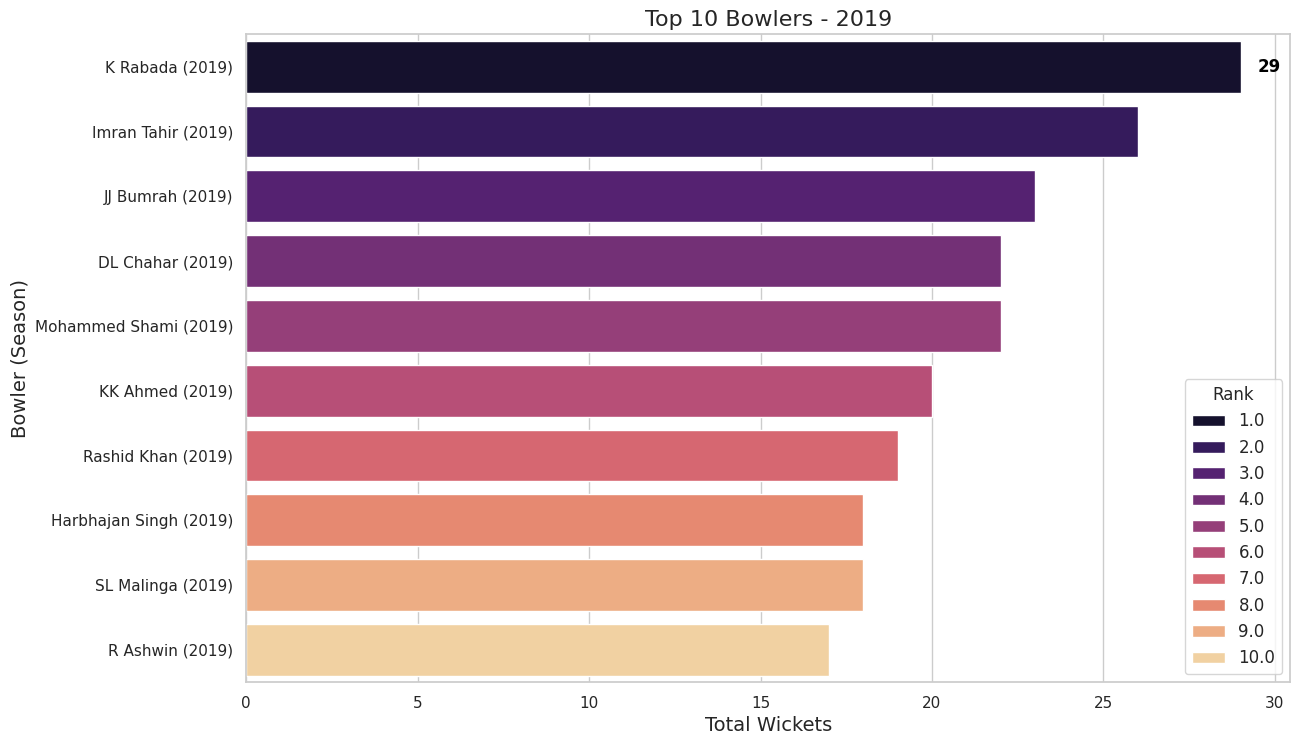

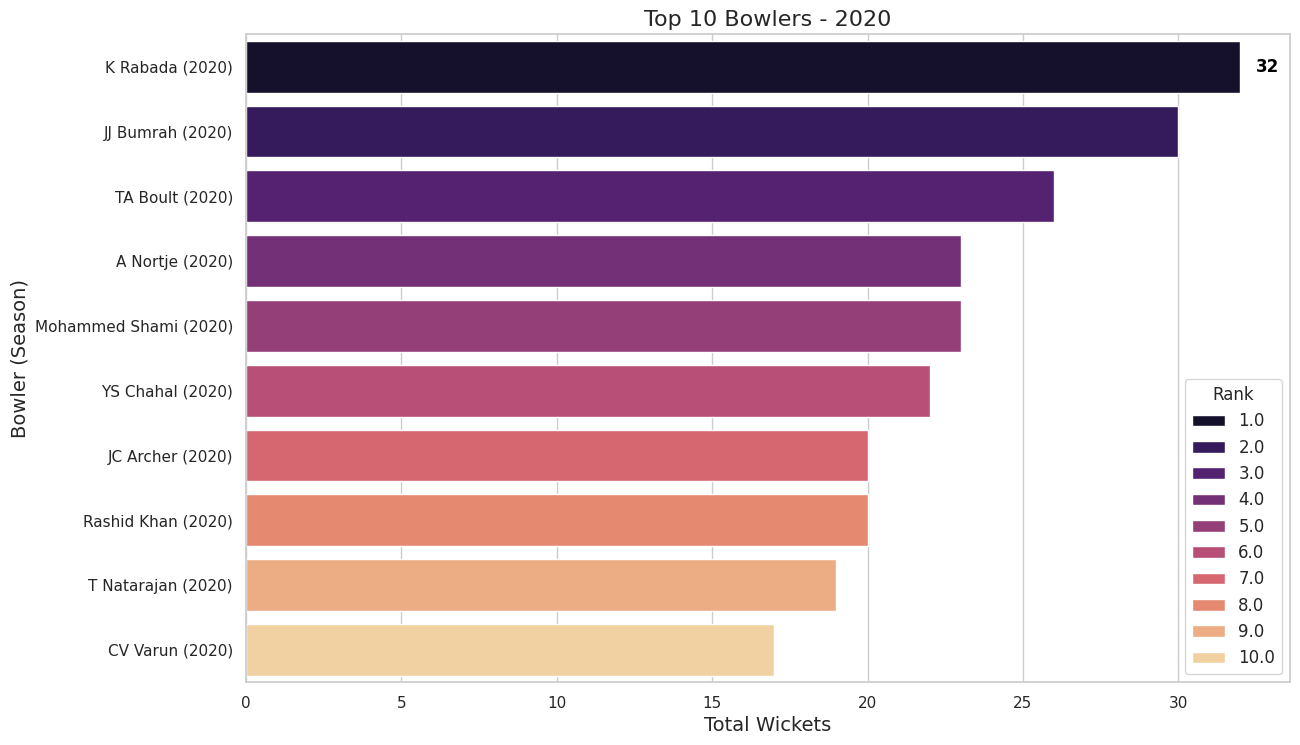

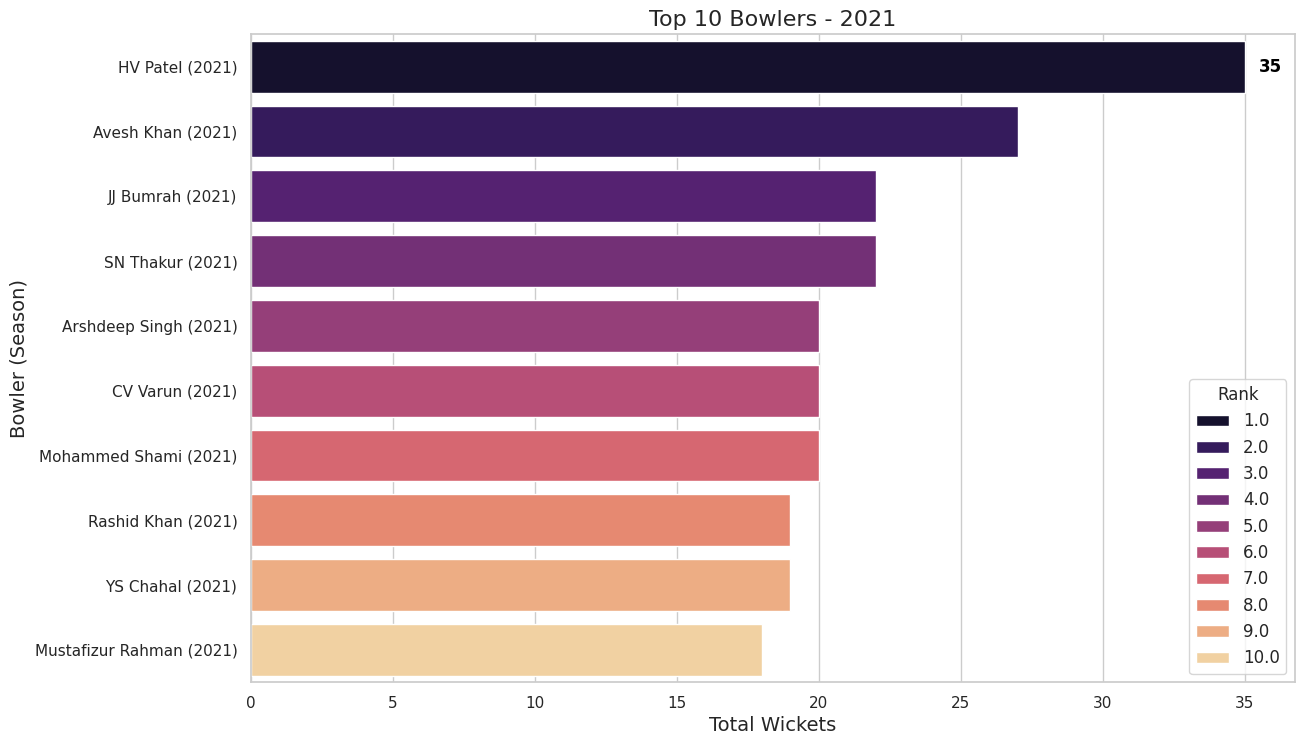

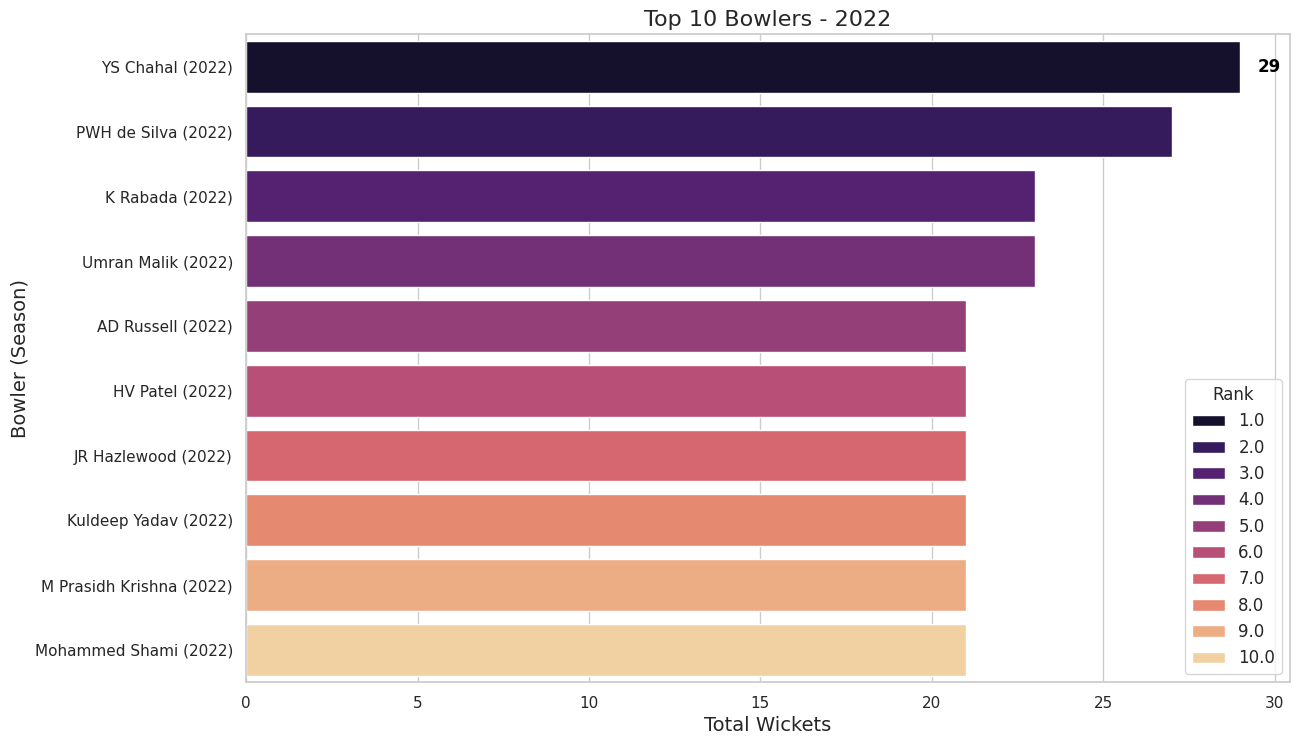

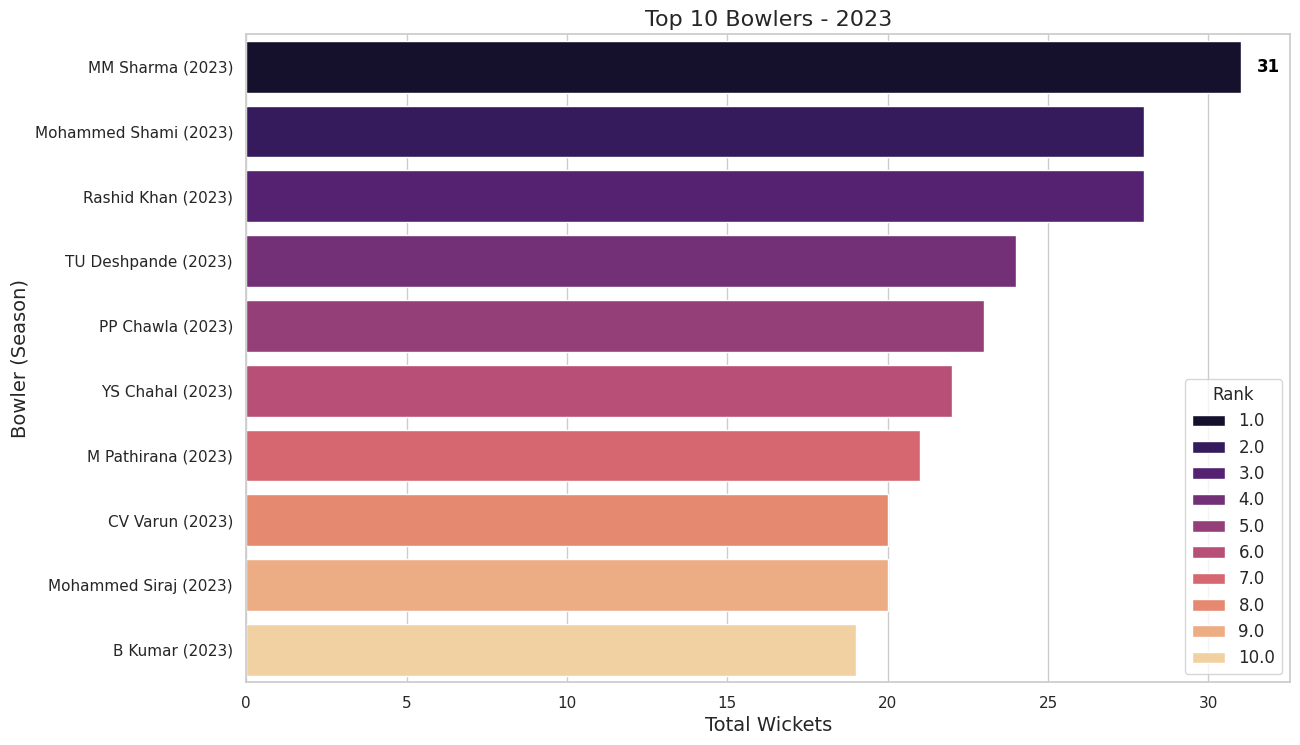

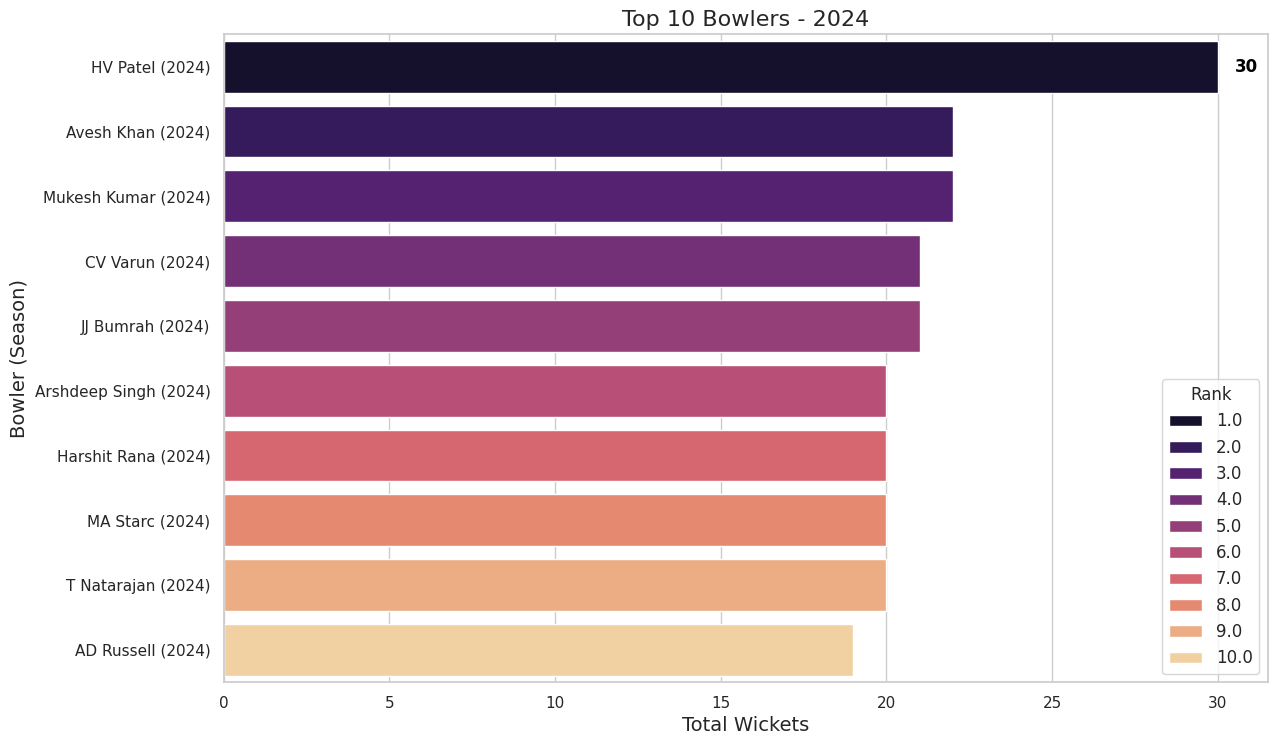

In [60]:
top_10_bowlers['bowler_season'] = top_10_bowlers['bowler'] + " (" + top_10_bowlers['season'].astype(str) + ")"

# Get unique seasons
seasons = top_10_bowlers['season'].unique()

for season in sorted(seasons):
    season_data = top_10_bowlers[top_10_bowlers['season'] == season]
    
    plt.figure(figsize=(12, 8))
    
    # Horizontal bar plot with Rank as Hue
    ax = sns.barplot(
        data=season_data, y='bowler_season', x='total_wickets', 
        hue='rank', palette='magma', dodge=False, orient='h'
    )
    
    # Annotate each bar with the player's name and wickets
    for bar, total_wickets in zip(ax.patches, season_data['total_wickets']):
        ax.text(bar.get_width() + 0.5,  # Slightly outside the bar
                bar.get_y() + bar.get_height() / 2,  # Center vertically
                f"{total_wickets}", 
                color='black', ha='left', va='center', fontsize=12, fontweight='bold')
    
    plt.xlabel("Total Wickets", fontsize=14)
    plt.ylabel("Bowler (Season)", fontsize=14)
    plt.title(f'Top 10 Bowlers - {season}', fontsize=16)
    
    # Add legend with rank
    plt.legend(title="Rank", fontsize=12, loc='lower right')
    plt.show()


# Feature Extraction:

In [61]:
matches.columns,deliveries.columns

(Index(['id', 'season', 'city', 'date', 'match_type', 'player_of_match',
        'venue', 'team1', 'team2', 'toss_winner', 'toss_decision', 'winner',
        'result', 'result_margin', 'target_runs', 'target_overs', 'super_over',
        'method', 'umpire1', 'umpire2'],
       dtype='object'),
 Index(['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
        'batter', 'bowler', 'non_striker', 'batsman_runs', 'extra_runs',
        'total_runs', 'extras_type', 'is_wicket', 'player_dismissed',
        'dismissal_kind', 'fielder'],
       dtype='object'))

In [62]:
city_venue_counts = matches.groupby('city')['venue'].nunique()

# Find cities with more than one unique venue
cities_with_multiple_venues = city_venue_counts[city_venue_counts > 1]

# Print results
if cities_with_multiple_venues.empty:
    print("Every city has the same venue.")
else:
    print("Cities with multiple venues:")
    print(cities_with_multiple_venues)

Cities with multiple venues:
city
Abu Dhabi        2
Ahmedabad        2
Bengaluru        2
Chandigarh       4
Chennai          3
Delhi            3
Dharamsala       2
Hyderabad        3
Jaipur           2
Kolkata          2
Mumbai           6
Pune             3
Visakhapatnam    2
Name: venue, dtype: int64


In [63]:
matches['match_type'].unique()

array(['League', 'Semi Final', 'Final', '3rd Place Play-Off',
       'Qualifier 1', 'Elimination Final', 'Qualifier 2', 'Eliminator'],
      dtype=object)

In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split



df = matches.copy()

# Drop less impactful columns
df.drop(columns=['umpire1', 'umpire2', 'super_over', 'player_of_match'], inplace=True)

# Convert Date to Indian Seasons
def map_to_indian_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4]:
        return "Spring"
    elif month in [5, 6]:
        return "Summer"
    elif month in [7, 8, 9]:
        return "Monsoon"
    else:
        return "Autumn"


df['month'] = pd.to_datetime(df['date']).dt.month
df['season_month'] = df['month'].apply(map_to_indian_season)
df.drop(columns=['date', 'month'], inplace=True)



# Merge Toss Decision into team_to_bat_first & team_to_ball_first
df['team_to_bat_first'] = df.apply(lambda row: row['toss_winner'] if row['toss_decision'] == 'bat' else (row['team1'] if row['team1'] != row['toss_winner'] else row['team2']), axis=1)
df['team_to_ball_first'] = df.apply(lambda row: row['team1'] if row['team1'] != row['team_to_bat_first'] else row['team2'], axis=1)
df.drop(columns=['toss_winner', 'toss_decision', 'team1', 'team2'], inplace=True)

# Track Previous Wins & Losses Per Season
df['previous_wins'] = df.groupby(['season', 'winner']).cumcount()
df['previous_losses'] = df.apply(lambda row: df[(df['season'] == row['season']) & ((df['winner'] != row['winner']) & (df['team_to_bat_first'] == row['winner']) | (df['team_to_ball_first'] == row['winner']))].shape[0], axis=1)

# Compute Average Win & Loss Margins
df['win_margin'] = df.groupby(['season', 'winner'])['result_margin'].expanding().mean().reset_index(level=[0,1], drop=True)
df['loss_margin'] = df.apply(lambda row: df[(df['season'] == row['season']) & ((df['winner'] != row['winner']) & ((df['team_to_bat_first'] == row['winner']) | (df['team_to_ball_first'] == row['winner'])))]['result_margin'].mean(), axis=1)

# Prepare Feature Set (X) and Target Variable (y)
X = df[['season','city', 'venue', 'season_month', 'match_type', 'team_to_bat_first', 'team_to_ball_first', 'previous_wins', 'previous_losses', 'win_margin', 'loss_margin']]
y = df['winner']
#------------------------------------------------------------------------------------






In [20]:
# Define categorical and numerical columns
categorical_cols1 = ['season', 'season_month']
categorical_cols2 = ['city', 'venue', 'match_type', 'team_to_bat_first', 'team_to_ball_first']
numerical_cols = ['previous_wins', 'previous_losses', 'win_margin', 'loss_margin']

# Initialize encoders
encoder1 = OrdinalEncoder()  
encoder2 = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply encoding
X_train_encoded1 = encoder1.fit_transform(X_train[categorical_cols1])
X_test_encoded1 = encoder1.transform(X_test[categorical_cols1])

X_train_encoded2 = encoder2.fit_transform(X_train[categorical_cols2])
X_test_encoded2 = encoder2.transform(X_test[categorical_cols2])

# No need to scale for Random Forest
X_train_final = np.hstack((X_train_encoded1, X_train_encoded2, X_train[numerical_cols].values))
X_test_final = np.hstack((X_test_encoded1, X_test_encoded2, X_test[numerical_cols].values))

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_final, y_train)

# Predictions
y_pred = rf_model.predict(X_test_final)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

# Print classification report and average F1-score
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))

Random Forest Accuracy: 0.7248

Classification Report:
                              precision    recall  f1-score   support

        Chennai Super Kings       0.71      0.79      0.75        28
             Delhi Capitals       0.67      0.61      0.64        23
              Gujarat Lions       1.00      1.00      1.00         3
             Gujarat Titans       0.86      1.00      0.92         6
            Kings XI Punjab       0.75      0.67      0.71        18
       Kochi Tuskers Kerala       1.00      0.00      0.00         1
      Kolkata Knight Riders       0.73      0.85      0.79        26
       Lucknow Super Giants       0.75      0.60      0.67         5
             Mumbai Indians       0.74      0.69      0.71        29
              Pune Warriors       1.00      0.50      0.67         2
               Punjab Kings       1.00      0.60      0.75         5
           Rajasthan Royals       0.64      0.82      0.72        22
     Rising Pune Supergiant       1.00      0.

In [41]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report


XG_label_encoder = LabelEncoder()
y_train_encoded = XG_label_encoder.fit_transform(y_train)
y_test_encoded = XG_label_encoder.transform(y_test)

# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Train the XGBoost model
xgb_model.fit(X_train_final, y_train_encoded)

# Predictions
y_pred = xgb_model.predict(X_test_final)

# Evaluate performance
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"XGBoost Accuracy: {accuracy:.4f}")

# Get the mapping of encoded labels to original classes
label_mapping = {index: label for index, label in enumerate(XG_label_encoder.classes_)}

# Print the mapping
print("Label Encoding Mapping:")
for key, value in label_mapping.items():
    print(f"{key} -> {value}")


# Print classification report and average F1-score
print("\nClassification Report:\n", classification_report(y_test, y_pred_cat, zero_division=1,digits=4))


XGBoost Accuracy: 0.8486
Label Encoding Mapping:
0 -> Chennai Super Kings
1 -> Delhi Capitals
2 -> Gujarat Lions
3 -> Gujarat Titans
4 -> Kings XI Punjab
5 -> Kochi Tuskers Kerala
6 -> Kolkata Knight Riders
7 -> Lucknow Super Giants
8 -> Mumbai Indians
9 -> Pune Warriors
10 -> Punjab Kings
11 -> Rajasthan Royals
12 -> Rising Pune Supergiant
13 -> Rising Pune Supergiants
14 -> Royal Challengers Bangalore
15 -> Royal Challengers Bengaluru
16 -> Sunrisers Hyderabad

Classification Report:
                              precision    recall  f1-score   support

        Chennai Super Kings     0.8571    0.8571    0.8571        28
             Delhi Capitals     0.7727    0.7391    0.7556        23
              Gujarat Lions     1.0000    1.0000    1.0000         3
             Gujarat Titans     1.0000    1.0000    1.0000         6
            Kings XI Punjab     0.8889    0.8889    0.8889        18
       Kochi Tuskers Kerala     1.0000    1.0000    1.0000         1
      Kolkata Knight Rid

In [40]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train CatBoost model
cat_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=200, random_seed=42)
cat_model.fit(X_train_final, y_train, eval_set=(X_test_final, y_test), early_stopping_rounds=50, verbose=100)

# Predictions
y_pred_cat = cat_model.predict(X_test_final)

# Evaluate performance
accuracy_cat = accuracy_score(y_test, y_pred_cat)
print(f"CatBoost Accuracy: {accuracy_cat:.4f}")

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_cat, zero_division=1,digits=4))


0:	learn: 2.7269245	test: 2.7436906	best: 2.7436906 (0)	total: 8.41ms	remaining: 8.4s
100:	learn: 0.5908892	test: 0.8678578	best: 0.8678578 (100)	total: 813ms	remaining: 7.23s
200:	learn: 0.2850537	test: 0.6169242	best: 0.6169242 (200)	total: 1.62s	remaining: 6.43s
300:	learn: 0.1808559	test: 0.5305220	best: 0.5305220 (300)	total: 2.42s	remaining: 5.63s
400:	learn: 0.1283127	test: 0.4828737	best: 0.4828737 (400)	total: 3.22s	remaining: 4.81s
500:	learn: 0.0973937	test: 0.4557525	best: 0.4557525 (500)	total: 4.06s	remaining: 4.05s
600:	learn: 0.0766218	test: 0.4364985	best: 0.4364985 (600)	total: 4.87s	remaining: 3.23s
700:	learn: 0.0636126	test: 0.4258281	best: 0.4258281 (700)	total: 5.65s	remaining: 2.41s
800:	learn: 0.0538963	test: 0.4162126	best: 0.4161456 (799)	total: 6.45s	remaining: 1.6s
900:	learn: 0.0466203	test: 0.4104383	best: 0.4104383 (900)	total: 7.24s	remaining: 795ms
999:	learn: 0.0410300	test: 0.4063743	best: 0.4062384 (998)	total: 8.02s	remaining: 0us

bestTest = 0.406